# Subtask B - Term Variants Clustering: Production Pipeline

This notebook implements a comprehensive production pipeline for clustering term variants in the waste management domain.

## Overview
- **Task**: Cluster terms that refer to the same underlying concept
- **Domain**: Municipal waste management (Italian)
- **Evaluation**: BCubed F1 Score

## Pipeline Components
1. Data loading and preprocessing
2. Linguistic preprocessing (lemmatization, POS tagging)
3. Multiple clustering approaches:
   - LLM-based clustering (Gemini)
   - Embedding-based semantic similarity
   - Hybrid approach
4. Evaluation and error analysis
5. Output generation


## 1. Setup and Imports


In [ ]:
import pandas as pd
import numpy as np
import json
import codecs
from collections import defaultdict, Counter
from typing import Dict, List, Set
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# NLP libraries
try:
    import spacy
    from spacy.lang.it import Italian
    SPACY_AVAILABLE = True
except ImportError:
    SPACY_AVAILABLE = False
    print("Warning: spaCy not available. Install with: pip install spacy && python -m spacy download it_core_news_sm")

# Embeddings
try:
    from sentence_transformers import SentenceTransformer
    SENTENCE_TRANSFORMERS_AVAILABLE = True
except ImportError:
    SENTENCE_TRANSFORMERS_AVAILABLE = False
    print("Warning: sentence-transformers not available. Install with: pip install sentence-transformers")

# LLM - Using Hugging Face Transformers (Open Source)
try:
    from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
    import torch
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Warning: transformers not available. Install with: pip install transformers torch")

print("Setup complete!")

















Setup complete!


## 2. Configuration


In [ ]:
class Config:
    """Configuration class for the clustering pipeline"""
    
    # Data paths
    TRAIN_PATH = "subtask_b_train.csv"
    DEV_PATH = "subtask_b_dev.csv"
    
    # Clustering parameters
    EMBEDDING_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"  # Multilingual model
    SIMILARITY_THRESHOLD = 0.75  # Threshold for semantic similarity clustering
    DBSCAN_EPS = 0.3  # DBSCAN epsilon parameter
    DBSCAN_MIN_SAMPLES = 2  # DBSCAN min_samples parameter
    
    # Strict clustering parameters (for anti-monster cluster pipeline)
    STRICT_SIMILARITY_THRESHOLD = 0.90  # Higher threshold for strict clustering
    MONSTER_CLUSTER_THRESHOLD = 10  # Cluster size threshold for breaking
    USE_LLM_VERIFICATION = False  # Whether to use LLM edge verification (slower)
    
    # LLM parameters (Open Source - Hugging Face)
    LLM_MODEL = "microsoft/Phi-3-mini-4k-instruct"  # Small, fast model. Alternative: "mistralai/Mistral-7B-Instruct-v0.2"
    LLM_USE_LOCAL = True  # Set to False to use Hugging Face API (requires API key)
    LLM_BATCH_SIZE = 10  # Number of terms per LLM batch (smaller for local models)
    LLM_TEMPERATURE = 0.1  # Lower temperature for more consistent outputs
    LLM_MAX_LENGTH = 512  # Maximum generation length
    
    # Linguistic preprocessing
    USE_LEMMATIZATION = True
    USE_POS_FILTERING = False  # Filter by POS tags if needed
    
    # Output
    OUTPUT_FORMAT = "csv"  # "json" or "csv" - CSV is recommended for submission
    OUTPUT_PREFIX = "production_run"
    
    # Evaluation
    EVALUATE_ON_DEV = True
    
    @classmethod
    def update(cls, **kwargs):
        """Update configuration parameters"""
        for key, value in kwargs.items():
            if hasattr(cls, key):
                setattr(cls, key, value)
            else:
                print(f"Warning: Unknown config parameter: {key}")

config = Config() 

## 5. Linguistic Preprocessing


## 3. Data Loading and Utilities


In [ ]:
def load_terms(file_path: str) -> Set[str]:
    """
    Load unique terms from CSV or JSON file.
    
    Args:
        file_path: Path to input file (CSV or JSON)
    
    Returns:
        Set of unique terms
    """
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        df.fillna('', inplace=True)
        terms = set([t.strip() for t in df['term'] if t != ''])
    elif file_path.endswith('.json'):
        with codecs.open(file_path, 'r', 'utf-8') as f:
            json_data = json.load(f)
        terms = set()
        for row in json_data.get("data", []):
            if "term_list" in row:
                terms.update(row["term_list"])
            elif "term" in row:
                terms.add(row["term"])
    else:
        raise ValueError("Unsupported file format. Only CSV and JSON files are supported.")
    return terms

def load_gold_standard(file_path: str) -> Dict[str, int]:
    """
    Load gold standard clustering from CSV or JSON file.
    
    Args:
        file_path: Path to gold standard file
    
    Returns:
        Dictionary mapping terms to cluster IDs
    """
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        data = {term: int(cluster) for term, cluster in df.itertuples(index=False)}
    elif file_path.endswith('.json'):
        with codecs.open(file_path, 'r', 'utf-8') as f:
            json_data = json.load(f)
        data = {item["term"]: item["cluster"] for item in json_data.get("data", [])}
    else:
        raise ValueError("Unsupported file format. Only CSV and JSON files are supported.")
    return data

def save_output(clustering: Dict[str, int], output_path: str, format: str = "csv"):
    """
    Save clustering results to file.
    
    Args:
        clustering: Dictionary mapping terms to cluster IDs
        output_path: Path to output file
        format: Output format ("json" or "csv")
    """
    import os
    
    # Ensure output directory exists
    output_dir = os.path.dirname(output_path) if os.path.dirname(output_path) else '.'
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Sort by cluster ID then term for consistent output
    sorted_items = sorted(clustering.items(), key=lambda x: (x[1], x[0]))
    
    if format == "json":
        json_data = {"data": []}
        for term, cluster in sorted_items:
            json_data["data"].append({"term": term, "cluster": int(cluster)})
        with codecs.open(output_path, 'w', 'utf-8') as f:
            json.dump(json_data, f, ensure_ascii=False, indent=2)
    elif format == "csv":
        df = pd.DataFrame([{"term": term, "cluster": int(cluster)}
                          for term, cluster in sorted_items])
        df.to_csv(output_path, index=False, encoding='utf-8')
    else:
        raise ValueError(f"Unsupported output format: {format}")
    
    abs_path = os.path.abspath(output_path)
    print(f"\n{'='*60}")
    print(f"PREDICTION FILE SAVED!")
    print(f"{'='*60}")
    print(f"  Location: {abs_path}")
    print(f"  Format: {format.upper()}")
    print(f"  Total terms: {len(clustering)}")
    print(f"  Total clusters: {len(set(clustering.values()))}")
    print(f"{'='*60}\n") 

## 4. BCubed Evaluation Metrics


In [ ]:
def train_optimal_threshold(train_file: str, method: str = "hybrid",
                             threshold_range: List[float] = None) -> float:
    """
    Train optimal similarity threshold on training data.
    
    Args:
        train_file: Path to training file with gold standard
        method: Clustering method to use
        threshold_range: List of thresholds to try (default: [0.65, 0.70, 0.75, 0.80, 0.85])
    
    Returns:
        Optimal threshold value
    """
    if threshold_range is None:
        threshold_range = [0.65, 0.70, 0.75, 0.80, 0.85]
    
    print(f"\n{'='*60}")
    print("Training: Finding Optimal Similarity Threshold")
    print(f"{'='*60}\n")
    
    # Load training data
    train_terms = load_terms(train_file)
    train_gold = load_gold_standard(train_file)
    train_terms_list = sorted(list(train_terms))
    
    print(f"Training on {len(train_terms_list)} terms from {train_file}")
    print(f"Trying thresholds: {threshold_range}\n")
    
    best_threshold = threshold_range[0]
    best_f1 = 0.0
    results = []
    
    for threshold in tqdm(threshold_range, desc="Testing thresholds"):
        # Temporarily update config
        original_threshold = config.SIMILARITY_THRESHOLD
        config.SIMILARITY_THRESHOLD = threshold
        
        try:
            # Run clustering with this threshold
            if method == "hybrid":
                embedding_clusterer = None
                if SENTENCE_TRANSFORMERS_AVAILABLE:
                    embedding_clusterer = EmbeddingClusterer(
                        similarity_threshold=threshold
                    )
                
                hybrid_clusterer = HybridClusterer(
                    preprocessor=preprocessor,
                    embedding_clusterer=embedding_clusterer,
                    llm_clusterer=None  # No LLM during training
                )
                clustering = hybrid_clusterer.cluster(train_terms_list, use_llm_refinement=False)
            elif method == "embedding":
                if not SENTENCE_TRANSFORMERS_AVAILABLE:
                    continue
                embedding_clusterer = EmbeddingClusterer(similarity_threshold=threshold)
                clustering = embedding_clusterer.cluster_by_similarity(train_terms_list)
            else:
                # For lemma method, threshold doesn't apply
                continue
            
            # Evaluate
            metrics = evaluate_clustering(train_gold, clustering, verbose=False)
            f1 = metrics['f1']
            results.append((threshold, f1, metrics['precision'], metrics['recall']))
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                
        except Exception as e:
            print(f"Error with threshold {threshold}: {e}")
            continue
        finally:
            config.SIMILARITY_THRESHOLD = original_threshold
    
    # Print results
    print(f"\n{'='*80}")
    print("TRAINING SET EVALUATION RESULTS")
    print(f"{'='*80}")
    print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
    print("-" * 80)
    for threshold, f1, precision, recall in results:
        marker = " [BEST]" if threshold == best_threshold else ""
        print(f"{threshold:<12.2f} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}{marker}")
    
    print(f"\n{'='*80}")
    print(f"Best threshold: {best_threshold:.3f}")
    print(f"Training Set BCubed F1 Score: {best_f1:.4f}")
    print(f"{'='*80}\n")
    
    # Update config with best threshold
    config.SIMILARITY_THRESHOLD = best_threshold
    
    # Save trained parameters to file for use on test data
    import os
    import json
    trained_params = {
        "optimal_threshold": best_threshold,
        "method": method,
        "train_file": train_file,
        "best_f1": best_f1,
        "training_date": pd.Timestamp.now().isoformat()
    }
    params_file = "trained_parameters.json"
    with open(params_file, 'w') as f:
        json.dump(trained_params, f, indent=2)
    print(f"Trained parameters saved to: {os.path.abspath(params_file)}")
    print(f"  These parameters will be used when running on test data.\n")
    
    return best_threshold

def load_trained_parameters(params_file: str = "trained_parameters.json") -> Dict:
    """
    Load trained parameters from file.
    
    Args:
        params_file: Path to trained parameters file
    
    Returns:
        Dictionary with trained parameters
    """
    import os
    import json
    
    if os.path.exists(params_file):
        with open(params_file, 'r') as f:
            params = json.load(f)
        print(f"Loaded trained parameters from: {os.path.abspath(params_file)}")
        print(f"  Optimal threshold: {params['optimal_threshold']:.3f}")
        print(f"  Method: {params['method']}")
        print(f"  Training F1: {params['best_f1']:.4f}\n")
        
        # Update config with loaded parameters
        config.SIMILARITY_THRESHOLD = params['optimal_threshold']
        
        return params
    else:
        print(f"WARNING: No trained parameters found at: {params_file}")
        print("   Using default parameters. Run training first!\n")
        return None 

In [ ]:
class BCubedCalculator:
    """BCubed metric calculator for clustering evaluation"""
    
    def __init__(self, gold: Dict[str, int], pred: Dict[str, int]):
        self.gold = gold
        self.pred = pred
        self.gold_cluster = defaultdict(set)
        self.pred_cluster = defaultdict(set)
        
        # Build cluster mappings
        for item, clus_id in gold.items():
            self.gold_cluster[clus_id].add(item)
        for item, clus_id in pred.items():
            self.pred_cluster[clus_id].add(item)
    
    def bc_precision_item(self, item: str) -> float:
        """Calculate BCubed precision for a single item"""
        pred_id = self.pred.get(item, None)
        gold_id = self.gold.get(item, None)
        
        if pred_id is None or gold_id is None:
            return 0.0
        
        pred_cluster = self.pred_cluster[pred_id]
        gold_cluster = self.gold_cluster[gold_id]
        
        TP = len(pred_cluster.intersection(gold_cluster))
        FP = len(pred_cluster) - TP
        
        if TP + FP == 0:
            return 0.0
        return TP / (TP + FP)
    
    def bc_recall_item(self, item: str) -> float:
        """Calculate BCubed recall for a single item"""
        pred_id = self.pred.get(item, None)
        gold_id = self.gold.get(item, None)
        
        if pred_id is None or gold_id is None:
            return 0.0
        
        pred_cluster = self.pred_cluster[pred_id]
        gold_cluster = self.gold_cluster[gold_id]
        
        TP = len(pred_cluster.intersection(gold_cluster))
        FN = len(gold_cluster) - TP
        
        if TP + FN == 0:
            return 0.0
        return TP / (TP + FN)

def bcubed_precision(gold: Dict[str, int], pred: Dict[str, int]) -> float:
    """Calculate BCubed precision"""
    calc = BCubedCalculator(gold, pred)
    pred_items = list(calc.pred.keys())
    if not pred_items:
        return 0.0
    return np.average([calc.bc_precision_item(item) for item in pred_items])

def bcubed_recall(gold: Dict[str, int], pred: Dict[str, int]) -> float:
    """Calculate BCubed recall"""
    calc = BCubedCalculator(gold, pred)
    gold_items = list(calc.gold.keys())
    if not gold_items:
        return 0.0
    return np.average([calc.bc_recall_item(item) for item in gold_items])

def bcubed_f1(gold: Dict[str, int], pred: Dict[str, int]) -> float:
    """Calculate BCubed F1 score"""
    precision = bcubed_precision(gold, pred)
    recall = bcubed_recall(gold, pred)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def evaluate_clustering(gold: Dict[str, int], pred: Dict[str, int], verbose: bool = True) -> Dict[str, float]:
    """
    Evaluate clustering results using BCubed metrics.
    
    Returns:
        Dictionary with precision, recall, and F1 scores
    """
    precision = bcubed_precision(gold, pred)
    recall = bcubed_recall(gold, pred)
    f1 = bcubed_f1(gold, pred)
    
    if verbose:
        print(f"BCubed Precision: {precision:.4f}")
        print(f"BCubed Recall: {recall:.4f}")
        print(f"BCubed F1 Score: {f1:.4f}")
    
    return {"precision": precision, "recall": recall, "f1": f1} 

In [ ]:
class LinguisticPreprocessor:
    """Linguistic preprocessing for Italian terms"""
    
    def __init__(self, use_lemmatization: bool = True):
        self.use_lemmatization = use_lemmatization
        self.nlp = None
        
        if use_lemmatization and SPACY_AVAILABLE:
            try:
                self.nlp = spacy.load("it_core_news_sm")
                print("Loaded Italian spaCy model")
            except OSError:
                print("Warning: Italian spaCy model not found. Install with: python -m spacy download it_core_news_sm")
                self.nlp = None
    
    def normalize_term(self, term: str) -> str:
        """Normalize a term (lowercase, strip)"""
        return term.lower().strip()
    
    def lemmatize(self, term: str) -> str:
        """Lemmatize a term"""
        if self.nlp is None:
            return self.normalize_term(term)
        
        doc = self.nlp(term)
        lemmas = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]
        return " ".join(lemmas)
    
    def get_lemma_map(self, terms: Set[str]) -> Dict[str, str]:
        """Create mapping from terms to their lemmas"""
        lemma_map = {}
        for term in tqdm(terms, desc="Lemmatizing terms"):
            lemma_map[term] = self.lemmatize(term)
        return lemma_map
    
    def group_by_lemma(self, terms: Set[str]) -> Dict[str, List[str]]:
        """Group terms by their lemmas"""
        lemma_map = self.get_lemma_map(terms)
        lemma_groups = defaultdict(list)
        for term, lemma in lemma_map.items():
            lemma_groups[lemma].append(term)
        return dict(lemma_groups)

# Initialize preprocessor
preprocessor = LinguisticPreprocessor(use_lemmatization=config.USE_LEMMATIZATION) 

Loaded Italian spaCy model


## 6. Embedding-Based Clustering


In [ ]:
class EmbeddingClusterer:
    """Clustering based on semantic embeddings"""
    
    def __init__(self, model_name: str = None, similarity_threshold: float = 0.75):
        self.model_name = model_name or config.EMBEDDING_MODEL
        self.similarity_threshold = similarity_threshold
        self.model = None
        self.embeddings = None
        
        if SENTENCE_TRANSFORMERS_AVAILABLE:
            print(f"Loading embedding model: {self.model_name}")
            self.model = SentenceTransformer(self.model_name)
            print("Model loaded successfully")
        else:
            print("Warning: sentence-transformers not available")
    
    def compute_embeddings(self, terms: List[str]) -> np.ndarray:
        """Compute embeddings for a list of terms"""
        if self.model is None:
            raise ValueError("Embedding model not loaded")
        
        print(f"Computing embeddings for {len(terms)} terms...")
        embeddings = self.model.encode(terms, show_progress_bar=True, convert_to_numpy=True)
        return embeddings
    
    def cluster_by_similarity(self, terms: List[str], embeddings: np.ndarray = None) -> Dict[str, int]:
        """
        Cluster terms based on cosine similarity threshold.
        Uses a greedy approach to assign terms to clusters.
        """
        if embeddings is None:
            embeddings = self.compute_embeddings(terms)
        
        # Compute similarity matrix
        similarity_matrix = cosine_similarity(embeddings)
        
        # Initialize clustering
        clustering = {}
        cluster_id = 1
        assigned = set()
        
        # Greedy clustering: assign each term to the first cluster it's similar to
        for i, term in enumerate(terms):
            if term in assigned:
                continue
            
            # Find similar terms
            similar_indices = np.where(similarity_matrix[i] >= self.similarity_threshold)[0]
            
            if len(similar_indices) > 1:  # Found similar terms
                # Assign all similar terms to the same cluster
                for idx in similar_indices:
                    if terms[idx] not in assigned:
                        clustering[terms[idx]] = cluster_id
                        assigned.add(terms[idx])
                cluster_id += 1
            else:  # No similar terms found, create singleton cluster
                clustering[term] = cluster_id
                assigned.add(term)
                cluster_id += 1
        
        return clustering
    
    def cluster_with_dbscan(self, terms: List[str], embeddings: np.ndarray = None, 
                           eps: float = 0.3, min_samples: int = 2) -> Dict[str, int]:
        """
        Cluster terms using DBSCAN algorithm on embeddings.
        """
        if embeddings is None:
            embeddings = self.compute_embeddings(terms)
        
        # Convert similarity to distance (1 - similarity)
        similarity_matrix = cosine_similarity(embeddings)
        distance_matrix = 1 - similarity_matrix
        
        # Apply DBSCAN
        clustering_alg = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        labels = clustering_alg.fit_predict(distance_matrix)
        
        # Convert labels to cluster IDs (DBSCAN uses -1 for noise)
        clustering = {}
        max_cluster_id = 0
        
        for term, label in zip(terms, labels):
            if label == -1:  # Noise point, assign to new cluster
                clustering[term] = max_cluster_id + 1
                max_cluster_id += 1
            else:
                clustering[term] = int(label) + 1  # Shift to start from 1
        
        return clustering
    
    def cluster_with_hierarchical(self, terms: List[str], embeddings: np.ndarray = None,
                                 n_clusters: int = None, linkage_method: str = 'ward') -> Dict[str, int]:
        """
        Cluster terms using hierarchical clustering.
        """
        if embeddings is None:
            embeddings = self.compute_embeddings(terms)
        
        if n_clusters is None:
            # Estimate number of clusters (rough heuristic: ~10% of terms)
            n_clusters = max(2, len(terms) // 10)
        
        clustering_alg = AgglomerativeClustering(
            n_clusters=n_clusters, 
            linkage=linkage_method,
            metric='cosine'
        )
        labels = clustering_alg.fit_predict(embeddings)
        
        clustering = {term: int(label) + 1 for term, label in zip(terms, labels)}
        return clustering 

## 7. LLM-Based Clustering


In [ ]:
class LLMClusterer:
    """Clustering using Large Language Models (Hugging Face Transformers - Open Source)"""
    
    def __init__(self, model_name: str = None, batch_size: int = 10, use_local: bool = True):
        self.model_name = model_name or config.LLM_MODEL
        self.batch_size = batch_size
        self.use_local = use_local
        self.tokenizer = None
        self.model = None
        self.pipeline = None
        
        if TRANSFORMERS_AVAILABLE:
            try:
                if use_local:
                    print(f"Loading local model: {self.model_name}")
                    print("Note: First run will download the model (~2-14GB depending on model)")
                    
                    # Use a smaller, faster model for local inference
                    if "Phi-3" not in self.model_name and "mistral" not in self.model_name.lower():
                        # Default to a smaller model
                        self.model_name = "microsoft/Phi-3-mini-4k-instruct"
                        print(f"Using smaller model: {self.model_name}")
                    
                    self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
                    self.model = AutoModelForCausalLM.from_pretrained(
                        self.model_name,
                        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                        device_map="auto" if torch.cuda.is_available() else None,
                        trust_remote_code=True
                    )
                    
                    # Create pipeline for easier text generation
                    self.pipeline = pipeline(
                        "text-generation",
                        model=self.model,
                        tokenizer=self.tokenizer,
                        device=0 if torch.cuda.is_available() else -1,
                        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
                    )
                    print(f"Model loaded successfully on {'GPU' if torch.cuda.is_available() else 'CPU'}")
                else:
                    # Use Hugging Face Inference API (requires API key)
                    print("Using Hugging Face Inference API")
                    try:
                        from huggingface_hub import InferenceClient
                        import os
                        api_key = os.getenv('HUGGINGFACE_API_KEY')
                        if not api_key:
                            api_key = input("Please enter your Hugging Face API key (or press Enter to skip LLM): ")
                        if api_key:
                            self.client = InferenceClient(model=self.model_name, token=api_key)
                        else:
                            print("No API key provided. LLM clustering will be skipped.")
                    except ImportError:
                        print("huggingface_hub not installed. Install with: pip install huggingface_hub")
            except Exception as e:
                print(f"Warning: Could not load LLM model: {e}")
                print("LLM clustering will be disabled. Consider using 'embedding' or 'hybrid' methods.")
        else:
            print("Warning: transformers not available")
    
    def create_system_prompt(self) -> str:
        """Create system prompt for clustering"""
        return f"""You are a term clustering agent specialized in Italian municipal waste management terminology.

You will receive a list of existing clusters and a list of unclustered terms.
Your task is to cluster together terms that refer to the same underlying concept.

Rules:
1. Group terms by meaning, not form. Consider their lemmas and semantic meaning.
2. Focus on their meaning within the municipal waste management context.
3. Inflected forms of the same lemma should be clustered together (e.g., "isola ecologica" and "isole ecologiche").
4. Acronyms, initialisms, and their full forms should be clustered together (e.g., "ccr" and "centro comunale di raccolta").
5. Synonyms should be clustered together (e.g., "isola ecologica" and "centro comunale di raccolta").
6. Hypernyms and hyponyms should NOT be clustered together (e.g., "rifiuti" and "rifiuti indifferenziati" must be in different clusters).
7. Each cluster must represent a single, well-defined concept.

Output format:
Return the list of clusters with newly added terms. Each cluster must be on a new line.
Terms within a cluster should be separated by semicolons.

Example Output:
centro di raccolta; ccr; isola ecologica; isole ecologiche
indifferenziato; secco residuo
raccolta porta a porta; raccolta domiciliare

Instructions:
- If a term does not belong to any existing cluster, create a new cluster for it.
- Do not remove terms from existing clusters.
- Your response must contain only the clustered terms in the specified format. Do not add any introductory text or explanations.
- Process all {self.batch_size} unclustered terms.
"""
    
    def parse_clusters(self, cluster_text: str) -> List[List[str]]:
        """Parse cluster text into list of clusters"""
        clusters = []
        for line in cluster_text.strip().split('\n'):
            line = line.strip()
            if not line:
                continue
            # Split by semicolon and clean terms
            terms = [t.strip() for t in line.split(';') if t.strip()]
            if terms:
                clusters.append(terms)
        return clusters
    
    def cluster_terms(self, terms: List[str], initial_clusters: List[List[str]] = None) -> Dict[str, int]:
        """
        Cluster terms using LLM in batches.
        
        Args:
            terms: List of terms to cluster
            initial_clusters: Optional initial clusters (from previous batches)
        
        Returns:
            Dictionary mapping terms to cluster IDs
        """
        if self.pipeline is None and not hasattr(self, 'client'):
            raise ValueError("LLM model not initialized")
        
        # Initialize clusters
        if initial_clusters is None:
            clusters = []
        else:
            clusters = [cluster.copy() for cluster in initial_clusters]
        
        # Process terms in batches
        system_prompt = self.create_system_prompt()
        
        for batch_start in tqdm(range(0, len(terms), self.batch_size), desc="Processing batches"):
            batch_terms = terms[batch_start:batch_start + self.batch_size]
            
            # Format existing clusters
            if clusters:
                cluster_text = "\n".join(["; ".join(cluster) for cluster in clusters])
                user_prompt = f"CLUSTERS:\n{cluster_text}\n\nUNCLUSTERED TERMS:\n" + "\n".join(batch_terms)
            else:
                user_prompt = f"UNCLUSTERED TERMS:\n" + "\n".join(batch_terms)
            
            # Get LLM response
            try:
                if self.pipeline is not None:
                    # Local model inference
                    full_prompt = f"{system_prompt}\n\n{user_prompt}\n\nOutput:"
                    response = self.pipeline(
                        full_prompt,
                        max_new_tokens=config.LLM_MAX_LENGTH,
                        temperature=config.LLM_TEMPERATURE,
                        do_sample=True,
                        return_full_text=False,
                        truncation=True
                    )
                    response_text = response[0]['generated_text'].strip()
                elif hasattr(self, 'client'):
                    # Hugging Face API
                    response = self.client.text_generation(
                        f"{system_prompt}\n\n{user_prompt}\n\nOutput:",
                        max_new_tokens=config.LLM_MAX_LENGTH,
                        temperature=config.LLM_TEMPERATURE
                    )
                    response_text = response.strip()
                else:
                    raise ValueError("LLM model not initialized")
                
                # Clean response - remove instruction text that might be included
                lines = response_text.split('\n')
                cleaned_lines = []
                skip_keywords = ['instructions:', 'example', 'output format:', 'rules:', 'return the list']
                for line in lines:
                    line = line.strip()
                    if not line:
                        continue
                    line_lower = line.lower()
                    # Skip instruction lines (unless they contain semicolons, which means they're clusters)
                    if any(keyword in line_lower for keyword in skip_keywords) and ';' not in line:
                        continue
                    # Skip lines that are clearly instructions
                    if line_lower.startswith(('instructions', 'example output', 'output format', 'rules')):
                        continue
                    cleaned_lines.append(line)
                
                response_text = '\n'.join(cleaned_lines).strip()
                
                # Parse response
                new_clusters = self.parse_clusters(response_text)
                
                # Update clusters
                clusters = new_clusters
                
            except Exception as e:
                print(f"Error processing batch: {e}")
                # Fallback: create singleton clusters for this batch
                for term in batch_terms:
                    clusters.append([term])
        
        # Convert clusters to dictionary
        clustering = {}
        for cluster_id, cluster in enumerate(clusters, start=1):
            for term in cluster:
                clustering[term] = cluster_id
        
        # Verify all input terms are in clustering
        input_terms_set = set(terms)
        clustered_terms_set = set(clustering.keys())
        missing_terms = input_terms_set - clustered_terms_set
        
        if missing_terms:
            print(f"\nWARNING: {len(missing_terms)} terms not found in LLM output. Adding as singletons...")
            max_cluster_id = max(clustering.values()) if clustering else 0
            for i, term in enumerate(sorted(missing_terms), start=1):
                clustering[term] = max_cluster_id + i
        
        return clustering 

In [ ]:
class HybridClusterer:
    """
    Hybrid clustering approach combining:
    1. Lemma-based grouping
    2. Embedding-based similarity
    3. LLM-based refinement
    """
    
    def __init__(self, preprocessor: LinguisticPreprocessor, 
                 embedding_clusterer: EmbeddingClusterer,
                 llm_clusterer: LLMClusterer = None):
        self.preprocessor = preprocessor
        self.embedding_clusterer = embedding_clusterer
        self.llm_clusterer = llm_clusterer
    
    def cluster(self, terms: List[str], use_llm_refinement: bool = False) -> Dict[str, int]:
        """
        Perform hybrid clustering.
        
        Strategy:
        1. Start with lemma-based grouping
        2. Use embeddings to merge similar clusters
        3. Optionally refine with LLM
        """
        print(f"Clustering {len(terms)} terms using hybrid approach...")
        
        # Step 1: Lemma-based initial clustering
        print("Step 1: Lemma-based grouping...")
        lemma_groups = self.preprocessor.group_by_lemma(set(terms))
        
        # Create initial clustering from lemma groups
        initial_clustering = {}
        cluster_id = 1
        for lemma, lemma_terms in lemma_groups.items():
            for term in lemma_terms:
                initial_clustering[term] = cluster_id
            cluster_id += 1
        
        # Step 2: Embedding-based refinement
        print("Step 2: Embedding-based refinement...")
        if self.embedding_clusterer.model is not None:
            embeddings = self.embedding_clusterer.compute_embeddings(terms)
            similarity_matrix = cosine_similarity(embeddings)
            
            # Merge clusters based on similarity
            term_to_idx = {term: i for i, term in enumerate(terms)}
            
            # Build cluster representatives (average embedding per cluster)
            cluster_embeddings = defaultdict(list)
            for term, cluster_id in initial_clustering.items():
                if term in term_to_idx:
                    cluster_embeddings[cluster_id].append(embeddings[term_to_idx[term]])
            
            cluster_repr = {cid: np.mean(embs, axis=0) for cid, embs in cluster_embeddings.items()}
            
            # Merge similar clusters
            cluster_ids = list(cluster_repr.keys())
            merged = {cid: cid for cid in cluster_ids}  # Track merges
            
            for i, cid1 in enumerate(cluster_ids):
                for cid2 in cluster_ids[i+1:]:
                    if merged[cid1] != merged[cid2]:
                        sim = cosine_similarity(
                            cluster_repr[cid1].reshape(1, -1),
                            cluster_repr[cid2].reshape(1, -1)
                        )[0][0]
                        
                        if sim >= config.SIMILARITY_THRESHOLD:
                            # Merge cid2 into cid1
                            target = merged[cid1]
                            source = merged[cid2]
                            for cid in cluster_ids:
                                if merged[cid] == source:
                                    merged[cid] = target
            
            # Apply merges to clustering
            final_clustering = {term: merged[initial_clustering[term]] for term in terms}
            
            # Renumber clusters to be consecutive
            unique_clusters = sorted(set(final_clustering.values()))
            cluster_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_clusters, start=1)}
            final_clustering = {term: cluster_mapping[cluster_id] 
                             for term, cluster_id in final_clustering.items()}
        else:
            final_clustering = initial_clustering
        
        # Step 3: Optional LLM refinement
        if use_llm_refinement and self.llm_clusterer is not None:
            print("Step 3: LLM-based refinement...")
            # Convert clustering to cluster lists for LLM
            cluster_lists = defaultdict(list)
            for term, cluster_id in final_clustering.items():
                cluster_lists[cluster_id].append(term)
            
            initial_clusters = [terms for terms in cluster_lists.values()]
            
            # Re-cluster with LLM (this will refine the clusters)
            llm_clustering = self.llm_clusterer.cluster_terms(terms, initial_clusters)
            final_clustering = llm_clustering
        
        return final_clustering 

## 8.4. Strict Hybrid Clustering (Anti-Monster Cluster Pipeline)

This refactored pipeline implements 4 strict modules to prevent "monster clusters" and improve precision:

1. **Pre-Processing**: Acronym & Substring Solver
2. **Refined Embedding Clustering**: Anti-Lumping Logic (threshold 0.90, domain stop-word penalty, antonym guardrail)
3. **Post-Processing**: Monster Cluster Breaker
4. **LLM Refinement**: Verification Only (YES/NO edge verification)


In [ ]:
import re
from difflib import SequenceMatcher

class AcronymSubstringSolver:
    """
    Module 1: Pre-Processing - Acronym & Substring Solver
    Deterministic rule-based step to lock obvious matches before embedding clustering.
    """
    
    # Domain stop-words that should NOT trigger substring matches
    DOMAIN_STOPWORDS = {
        'rifiuti', 'rifiuto', 'raccolta', 'servizio', 'servizi',
        'gestione', 'comunale', 'comune', 'municipale', 'municipio'
    }
    
    def __init__(self, preprocessor: LinguisticPreprocessor = None):
        self.preprocessor = preprocessor
        self.locked_pairs = set()  # Track locked term pairs
    
    def is_acronym(self, term: str) -> bool:
        """Check if a term is likely an acronym (all caps, short, no spaces)"""
        term_clean = term.strip().upper()
        # Acronym: 2-10 chars, all uppercase letters/numbers, no spaces
        if len(term_clean) >= 2 and len(term_clean) <= 10:
            if term_clean.replace(' ', '') == term_clean and term_clean.isalnum():
                # Check if it's mostly letters (at least 50%)
                if sum(c.isalpha() for c in term_clean) >= len(term_clean) * 0.5:
                    return True
        return False
    
    def extract_acronym_letters(self, term: str) -> str:
        """Extract potential acronym letters from a term (first letters of words)"""
        words = term.upper().split()
        # Get first letter of each significant word (skip articles/prepositions)
        articles = {'DI', 'DE', 'DEL', 'DELLA', 'DELLE', 'DEI', 'DEGLI', 'DA', 'E', 'A', 'AL', 'ALL', 'ALLA', 'ALLE'}
        letters = []
        for word in words:
            if word and word[0].isalpha() and word not in articles:
                letters.append(word[0])
        return ''.join(letters)
    
    def is_acronym_match(self, term1: str, term2: str) -> bool:
        """Check if term1 is an acronym of term2 or vice versa"""
        t1_upper = term1.upper().strip()
        t2_upper = term2.upper().strip()
        
        # Direct match
        if t1_upper == t2_upper:
            return True
        
        # Check if one is acronym and other is expansion
        if self.is_acronym(t1_upper):
            # term1 is acronym, check if it matches term2's letters
            t2_letters = self.extract_acronym_letters(term2)
            if t1_upper == t2_letters or t1_upper.replace(' ', '') == t2_letters:
                return True
        
        if self.is_acronym(t2_upper):
            # term2 is acronym, check if it matches term1's letters
            t1_letters = self.extract_acronym_letters(term1)
            if t2_upper == t1_letters or t2_upper.replace(' ', '') == t1_letters:
                return True
        
        return False
    
    def is_strict_substring_match(self, term1: str, term2: str) -> bool:
        """
        Check if terms match via exact substring (strict, excluding domain stop-words).
        Only matches if lemmatized forms are very similar.
        """
        if not self.preprocessor:
            return False
        
        # Get lemmas
        try:
            lemma1 = self.preprocessor.lemmatize(term1)
            lemma2 = self.preprocessor.lemmatize(term2)
        except:
            return False
        
        # Exact lemma match
        if lemma1.lower() == lemma2.lower():
            return True
        
        # Check if one is contained in the other (but not just due to stop-words)
        lemma1_lower = lemma1.lower()
        lemma2_lower = lemma2.lower()
        
        # Remove domain stop-words for comparison
        words1 = set(w for w in lemma1_lower.split() if w not in self.DOMAIN_STOPWORDS)
        words2 = set(w for w in lemma2_lower.split() if w not in self.DOMAIN_STOPWORDS)
        
        # If after removing stop-words, one is subset of other and they share significant words
        if words1 and words2:
            if words1.issubset(words2) or words2.issubset(words1):
                # Check if they share at least one significant word
                if words1 & words2:
                    return True
        
        return False
    
    def solve(self, terms: List[str]) -> Dict[str, int]:
        """
        Apply acronym and substring matching to create initial locked clusters.
        
        Returns:
            Dictionary mapping terms to cluster IDs (locked clusters)
        """
        print("Module 1: Acronym & Substring Solver")
        print(f"  Processing {len(terms)} terms...")
        
        clustering = {}
        cluster_id = 1
        assigned = set()
        locked_clusters = []  # List of locked cluster term sets
        
        # Process each term
        for i, term1 in enumerate(terms):
            if term1 in assigned:
                continue
            
            # Find matches for this term
            matches = [term1]
            
            for term2 in terms[i+1:]:
                if term2 in assigned:
                    continue
                
                # Check acronym match
                if self.is_acronym_match(term1, term2):
                    matches.append(term2)
                    self.locked_pairs.add((term1, term2))
                    assigned.add(term2)
                    continue
                
                # Check strict substring match
                if self.is_strict_substring_match(term1, term2):
                    matches.append(term2)
                    self.locked_pairs.add((term1, term2))
                    assigned.add(term2)
                    continue
            
            # Assign cluster ID to all matches
            for term in matches:
                clustering[term] = cluster_id
                assigned.add(term)
            
            if len(matches) > 1:
                locked_clusters.append(matches)
            
            cluster_id += 1
        
        print(f"  Created {len(locked_clusters)} locked clusters from acronym/substring matches")
        print(f"  {sum(len(c) for c in locked_clusters)} terms locked")
        
        return clustering 

In [ ]:
class RefinedEmbeddingClusterer:
    """
    Module 2: Refined Embedding Clustering - Anti-Lumping Logic
    Uses higher threshold (0.90), domain stop-word penalty, and antonym guardrail.
    """
    
    # Domain stop-words that should be penalized in similarity calculation
    DOMAIN_STOPWORDS = {
        'rifiuti', 'rifiuto', 'raccolta', 'servizio', 'servizi',
        'gestione', 'comunale', 'comune', 'municipale', 'municipio'
    }
    
    # Antonym pairs that should NOT be merged
    ANTONYM_PAIRS = [
        ('differenziata', 'indifferenziata'),
        ('differenziato', 'indifferenziato'),
        ('differenziati', 'indifferenziati'),
        ('secco', 'umido'),
        ('secca', 'umida'),
    ]
    
    def __init__(self, embedding_clusterer: EmbeddingClusterer,
                 similarity_threshold: float = 0.90):
        self.embedding_clusterer = embedding_clusterer
        self.similarity_threshold = similarity_threshold
    
    def has_antonym_conflict(self, term1: str, term2: str) -> bool:
        """Check if two terms contain antonyms"""
        term1_lower = term1.lower()
        term2_lower = term2.lower()
        
        for ant1, ant2 in self.ANTONYM_PAIRS:
            if ant1 in term1_lower and ant2 in term2_lower:
                return True
            if ant2 in term1_lower and ant1 in term2_lower:
                return True
        return False
    
    def calculate_penalized_similarity(self, term1: str, term2: str,
                                       base_similarity: float) -> float:
        """
        Apply domain stop-word penalty to similarity score.
        If terms only match due to stop-words, penalize heavily.
        """
        # Check if terms are identical (no penalty)
        if term1.lower() == term2.lower():
            return base_similarity
        
        # Extract non-stop-word tokens
        words1 = set(w.lower() for w in term1.split() if w.lower() not in self.DOMAIN_STOPWORDS)
        words2 = set(w.lower() for w in term2.split() if w.lower() not in self.DOMAIN_STOPWORDS)
        
        # If both have no significant words after removing stop-words, heavy penalty
        if not words1 or not words2:
            return base_similarity * 0.5  # 50% penalty
        
        # Calculate overlap of significant words
        if words1 & words2:
            # They share significant words, no penalty
            return base_similarity
        else:
            # They only share stop-words, apply penalty
            penalty = 0.3  # 70% penalty
            return base_similarity * penalty
    
    def cluster_with_anti_lumping(self, terms: List[str],
                                  initial_clustering: Dict[str, int],
                                  embeddings: np.ndarray) -> Dict[str, int]:
        """
        Perform refined embedding clustering with anti-lumping logic.
        
        Args:
            terms: List of all terms
            initial_clustering: Initial clustering from Module 1 (locked clusters)
            embeddings: Pre-computed embeddings
        
        Returns:
            Updated clustering dictionary
        """
        print("Module 2: Refined Embedding Clustering (Anti-Lumping)")
        print(f"  Using strict threshold: {self.similarity_threshold:.2f}")
        
        # Compute similarity matrix
        similarity_matrix = cosine_similarity(embeddings)
        term_to_idx = {term: i for i, term in enumerate(terms)}
        
        # Track which clusters are locked (from Module 1)
        locked_clusters = set(initial_clustering.values())
        cluster_members = defaultdict(set)
        for term, cid in initial_clustering.items():
            cluster_members[cid].add(term)
        
        # Build cluster representatives (average embedding per cluster)
        cluster_embeddings = defaultdict(list)
        for term, cluster_id in initial_clustering.items():
            if term in term_to_idx:
                cluster_embeddings[cluster_id].append(embeddings[term_to_idx[term]])
        
        cluster_repr = {cid: np.mean(embs, axis=0) for cid, embs in cluster_embeddings.items()}
        
        # Track merges (only for unlocked clusters)
        cluster_ids = list(cluster_repr.keys())
        merged = {cid: cid for cid in cluster_ids}
        
        # Try to merge clusters (but respect locked clusters and apply penalties)
        merge_count = 0
        for i, cid1 in enumerate(cluster_ids):
            for cid2 in cluster_ids[i+1:]:
                if merged[cid1] == merged[cid2]:
                    continue
                
                # Don't merge if both are locked clusters (from Module 1)
                if cid1 in locked_clusters and cid2 in locked_clusters:
                    continue
                
                # Calculate base similarity
                base_sim = cosine_similarity(
                    cluster_repr[cid1].reshape(1, -1),
                    cluster_repr[cid2].reshape(1, -1)
                )[0][0]
                
                # Get representative terms for penalty calculation
                rep_term1 = list(cluster_members[cid1])[0] if cluster_members[cid1] else ""
                rep_term2 = list(cluster_members[cid2])[0] if cluster_members[cid2] else ""
                
                # Check antonym conflict
                if rep_term1 and rep_term2 and self.has_antonym_conflict(rep_term1, rep_term2):
                    continue  # Skip merge due to antonym
                
                # Apply domain stop-word penalty
                penalized_sim = self.calculate_penalized_similarity(rep_term1, rep_term2, base_sim)
                
                # Merge only if penalized similarity exceeds threshold
                if penalized_sim >= self.similarity_threshold:
                    # Merge cid2 into cid1
                    target = merged[cid1]
                    source = merged[cid2]
                    for cid in cluster_ids:
                        if merged[cid] == source:
                            merged[cid] = target
                    merge_count += 1
        
        # Apply merges to clustering
        final_clustering = {}
        for term in terms:
            original_cid = initial_clustering.get(term, None)
            if original_cid is None:
                # Term not in initial clustering, assign to new cluster
                max_cid = max(merged.values()) if merged else 0
                final_clustering[term] = max_cid + 1
            else:
                final_clustering[term] = merged[original_cid]
        
        # Renumber clusters to be consecutive
        unique_clusters = sorted(set(final_clustering.values()))
        cluster_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_clusters, start=1)}
        final_clustering = {term: cluster_mapping[cluster_id]
                           for term, cluster_id in final_clustering.items()}
        
        print(f"  Merged {merge_count} cluster pairs (strict threshold applied)")
        print(f"  Final clusters: {len(unique_clusters)}")
        
        return final_clustering 

In [ ]:
class MonsterClusterBreaker:
    """
    Module 3: Post-Processing - Monster Cluster Breaker
    Identifies clusters with size > 10 and re-clusters them with stricter criteria.
    """
    
    def __init__(self, embedding_clusterer: EmbeddingClusterer,
                 refined_clusterer: RefinedEmbeddingClusterer,
                 monster_threshold: int = 10,
                 break_threshold: float = 0.85):
        self.embedding_clusterer = embedding_clusterer
        self.refined_clusterer = refined_clusterer
        self.monster_threshold = monster_threshold
        self.break_threshold = break_threshold  # Stricter threshold for breaking
    
    def break_monster_clusters(self, terms: List[str],
                              clustering: Dict[str, int],
                              embeddings: np.ndarray) -> Dict[str, int]:
        """
        Identify and break monster clusters (size > threshold).
        
        Args:
            terms: List of all terms
            clustering: Current clustering
            embeddings: Pre-computed embeddings
        
        Returns:
            Updated clustering with monster clusters broken
        """
        print("Module 3: Monster Cluster Breaker")
        
        # Group terms by cluster
        cluster_members = defaultdict(list)
        for term in terms:
            if term in clustering:
                cluster_members[clustering[term]].append(term)
        
        # Find monster clusters
        monster_clusters = {cid: members
                           for cid, members in cluster_members.items()
                           if len(members) > self.monster_threshold}
        
        if not monster_clusters:
            print(f"  No monster clusters found (all clusters ≤ {self.monster_threshold} items)")
            return clustering
        
        print(f"  Found {len(monster_clusters)} monster cluster(s) to break:")
        for cid, members in monster_clusters.items():
            print(f"    Cluster {cid}: {len(members)} items")
        
        # Create updated clustering
        updated_clustering = clustering.copy()
        term_to_idx = {term: i for i, term in enumerate(terms)}
        max_cluster_id = max(clustering.values()) if clustering else 0
        
        # Process each monster cluster
        break_count = 0
        for monster_cid, monster_terms in monster_clusters.items():
            if len(monster_terms) <= self.monster_threshold:
                continue
            
            print(f"  Breaking cluster {monster_cid} ({len(monster_terms)} items)...")
            
            # Get embeddings for this cluster
            monster_indices = [term_to_idx[t] for t in monster_terms if t in term_to_idx]
            if len(monster_indices) < 2:
                continue
            
            monster_embeddings = embeddings[monster_indices]
            
            # Use AgglomerativeClustering with stricter criteria
            # Determine number of clusters: aim for average cluster size of 3-5
            target_cluster_size = 4
            n_clusters = max(2, len(monster_terms) // target_cluster_size)
            
            # Use cosine distance with stricter linkage
            clustering_alg = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage='average',  # Average linkage is more conservative
                metric='cosine',
                distance_threshold=None
            )
            
            try:
                labels = clustering_alg.fit_predict(monster_embeddings)
                
                # Check internal similarity - if clusters are too dissimilar, break further
                new_cluster_groups = defaultdict(list)
                for term, label in zip(monster_terms, labels):
                    new_cluster_groups[label].append(term)
                
                # For each new sub-cluster, check if it should be broken further
                final_subclusters = {}
                current_new_cid = max_cluster_id + 1
                
                for sub_label, sub_terms in new_cluster_groups.items():
                    if len(sub_terms) <= 3:
                        # Small cluster, keep as is
                        for term in sub_terms:
                            final_subclusters[term] = current_new_cid
                        current_new_cid += 1
                    else:
                        # Check internal similarity
                        sub_indices = [term_to_idx[t] for t in sub_terms if t in term_to_idx]
                        if len(sub_indices) > 1:
                            sub_embeddings = embeddings[sub_indices]
                            sub_sim_matrix = cosine_similarity(sub_embeddings)
                            
                            # Calculate average internal similarity
                            n = len(sub_terms)
                            avg_sim = (sub_sim_matrix.sum() - n) / (n * (n - 1))  # Exclude diagonal
                            
                            if avg_sim >= self.break_threshold:
                                # High internal similarity, keep together
                                for term in sub_terms:
                                    final_subclusters[term] = current_new_cid
                                current_new_cid += 1
                            else:
                                # Low internal similarity, break into singletons or pairs
                                print(f"    Low internal similarity ({avg_sim:.3f}), breaking into smaller groups")
                                for term in sub_terms:
                                    final_subclusters[term] = current_new_cid
                                    current_new_cid += 1
                        else:
                            # Singleton
                            for term in sub_terms:
                                final_subclusters[term] = current_new_cid
                            current_new_cid += 1
                
                # Update clustering
                for term, new_cid in final_subclusters.items():
                    updated_clustering[term] = new_cid
                
                break_count += 1
                max_cluster_id = current_new_cid - 1
                
            except Exception as e:
                print(f"  Warning: Could not break cluster {monster_cid}: {e}")
                # Keep original cluster if breaking fails
                continue
        
        # Renumber all clusters to be consecutive
        unique_clusters = sorted(set(updated_clustering.values()))
        cluster_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_clusters, start=1)}
        final_clustering = {term: cluster_mapping[cluster_id]
                           for term, cluster_id in updated_clustering.items()}
        
        print(f"  Broke {break_count} monster cluster(s)")
        print(f"  Final cluster count: {len(unique_clusters)}")
        
        return final_clustering 

In [83]:
class LLMEdgeVerifier:  """
Module 4: LLM Refinement - Verification Only
Uses LLM to verify edges (term pairs) with YES/NO questions.
Only breaks links
if LLM says NO.  """   def __init__(self, llm_clusterer: LLMClusterer):  self.llm_clusterer = llm_clusterer
def verify_edge(self, term1: str, term2: str) -> bool:  """
Ask LLM
if two terms are synonyms referring to the exact same concept. 
Returns:
True
if LLM says YES (should be in same cluster), False
if NO  """  if self.llm_clusterer is None or (not hasattr(self.llm_clusterer, 'pipeline') and not hasattr(self.llm_clusterer, 'client')):  # LLM not available, skip verification (assume edge is valid)  return True   prompt = f"""Are '{term1}' and '{term2}' synonyms referring to the exact same concept in Italian municipal waste management?
Answer YES or NO only. Do not provide any explanation.
Answer:"""   try:  if hasattr(self.llm_clusterer, 'pipeline') and self.llm_clusterer.pipeline is not None:  # Local model  response = self.llm_clusterer.pipeline(  prompt,  max_new_tokens=10,  temperature=0.1,  do_sample=False,  return_full_text=False  )  answer = response[0]['generated_text'].strip().upper()  elif hasattr(self.llm_clusterer, 'client') and self.llm_clusterer.client is not None:  # API  response = self.llm_clusterer.client.text_generation(  prompt,  max_new_tokens=10,  temperature=0.1  )  answer = response.strip().upper()  else:  return True # Default to keeping edge
if LLM unavailable
# Parse YES/NO
if 'YES' in answer or 'SI' in answer:  return True
elif 'NO' in answer:  return False
else:  # Unclear response, default to keeping edge (conservative)  return True
except Exception as e:  # Error in LLM call, default to keeping edge
return True
def verify_clustering_edges(self, terms: List[str],  clustering: Dict[str, int]) -> Dict[str, int]:  """
Verify edges in clustering and break links where LLM says NO. 
Strategy:  - For each cluster, check pairs of terms  - If LLM says NO, break the link (assign to different clusters)  """  print("Module 4: LLM Edge Verification")   if self.llm_clusterer is None:  print(" WARNING: LLM not available, skipping verification")  return clustering
# Group terms by cluster  cluster_members = defaultdict(list)  for term in terms:  if term in clustering:  cluster_members[clustering[term]].append(term)   # Track edges to break  edges_to_break = set()  verified_count = 0
# For each cluster, verify edges
for cluster_id, members in cluster_members.items():  if len(members) < 2:  continue # Singleton, nothing to verify
# Check pairs in cluster
for i, term1 in enumerate(members):  for term2 in members[i+1:]:  verified_count += 1
if verified_count % 10 == 0:  print(f" Verified {verified_count} edges...", end='\r')   # Ask LLM  should_keep = self.verify_edge(term1, term2)   if not should_keep:  # LLM says NO, mark edge
for breaking  edges_to_break.add((term1, term2))   print(f"\n Verified {verified_count} edges")   if not edges_to_break:  print(" All edges verified as valid")  return clustering
print(f" WARNING: Breaking {len(edges_to_break)} invalid edges")   # Break edges by reassigning terms  updated_clustering = clustering.copy()  max_cluster_id = max(clustering.values()) if clustering else 0  new_cluster_id = max_cluster_id + 1
# For each broken edge, assign one term to a new cluster
for term1, term2 in edges_to_break:  # Keep term1 in original cluster, move term2 to new cluster  updated_clustering[term2] = new_cluster_id  new_cluster_id += 1
# Renumber clusters to be consecutive  unique_clusters = sorted(set(updated_clustering.values()))  cluster_mapping = {old_id: new_id
for new_id, old_id in enumerate(unique_clusters, start=1)}  final_clustering = {term: cluster_mapping[cluster_id]  for term, cluster_id in updated_clustering.items()}   print(f" Final cluster count: {len(unique_clusters)}")   return final_clustering 

In [ ]:
class StrictHybridClusterer:
    """
    Strict Hybrid Clustering Pipeline - Anti-Monster Cluster System
    Orchestrates 4 modules in order:
    1. Acronym & Substring Solver (pre-processing)
    2. Refined Embedding Clustering (anti-lumping logic)
    3. Monster Cluster Breaker (post-processing)
    4. LLM Edge Verification (verification only)
    """
    
    def __init__(self,
                 preprocessor: LinguisticPreprocessor,
                 embedding_clusterer: EmbeddingClusterer,
                 llm_clusterer: LLMClusterer = None,
                 similarity_threshold: float = 0.90,
                 monster_threshold: int = 10,
                 use_llm_verification: bool = False):
        """
        Initialize strict hybrid clusterer.
        
        Args:
            preprocessor: Linguistic preprocessor for lemmatization
            embedding_clusterer: Embedding clusterer for semantic similarity
            llm_clusterer: Optional LLM clusterer for edge verification
            similarity_threshold: Strict similarity threshold (default 0.90)
            monster_threshold: Cluster size threshold for breaking (default 10)
            use_llm_verification: Whether to use LLM edge verification (slower)
        """
        self.preprocessor = preprocessor
        self.embedding_clusterer = embedding_clusterer
        self.llm_clusterer = llm_clusterer
        self.similarity_threshold = similarity_threshold
        self.monster_threshold = monster_threshold
        self.use_llm_verification = use_llm_verification
        
        # Initialize modules
        self.acronym_solver = AcronymSubstringSolver(preprocessor=preprocessor)
        self.refined_clusterer = RefinedEmbeddingClusterer(
            embedding_clusterer=embedding_clusterer,
            similarity_threshold=similarity_threshold
        )
        self.monster_breaker = MonsterClusterBreaker(
            embedding_clusterer=embedding_clusterer,
            refined_clusterer=self.refined_clusterer,
            monster_threshold=monster_threshold
        )
        self.llm_verifier = LLMEdgeVerifier(llm_clusterer=llm_clusterer) if llm_clusterer else None
    
    def cluster(self, terms: List[str]) -> Dict[str, int]:
        """
        Perform strict hybrid clustering using all 4 modules.
        
        Args:
            terms: List of terms to cluster
        
        Returns:
            Dictionary mapping terms to cluster IDs
        """
        print(f"\n{'='*80}")
        print(f"STRICT HYBRID CLUSTERING PIPELINE")
        print(f"{'='*80}")
        print(f"Clustering {len(terms)} terms with anti-monster cluster system...")
        print(f"Similarity threshold: {self.similarity_threshold:.2f}")
        print(f"Monster cluster threshold: {self.monster_threshold} items")
        print(f"LLM verification: {'ON' if self.use_llm_verification else 'OFF'}")
        print(f"{'='*80}\n")
        
        # Module 1: Acronym & Substring Solver
        initial_clustering = self.acronym_solver.solve(terms)
        
        # Ensure all terms are in clustering (singletons for unmatched terms)
        max_cid = max(initial_clustering.values()) if initial_clustering else 0
        for term in terms:
            if term not in initial_clustering:
                max_cid += 1
                initial_clustering[term] = max_cid
        
        print()
        
        # Module 2: Refined Embedding Clustering
        if self.embedding_clusterer.model is not None:
            print("Computing embeddings...")
            embeddings = self.embedding_clusterer.compute_embeddings(terms)
            print()
            
            clustering = self.refined_clusterer.cluster_with_anti_lumping(
                terms=terms,
                initial_clustering=initial_clustering,
                embeddings=embeddings
            )
        else:
            print("WARNING: Embedding model not available, skipping Module 2")
            clustering = initial_clustering
        
        print()
        
        # Module 3: Monster Cluster Breaker
        if self.embedding_clusterer.model is not None:
            clustering = self.monster_breaker.break_monster_clusters(
                terms=terms,
                clustering=clustering,
                embeddings=embeddings
            )
        else:
            print("WARNING: Embedding model not available, skipping Module 3")
        
        print()
        
        # Module 4: LLM Edge Verification (optional)
        if self.use_llm_verification and self.llm_verifier is not None:
            clustering = self.llm_verifier.verify_clustering_edges(
                terms=terms,
                clustering=clustering
            )
        else:
            print("Module 4: LLM Edge Verification - SKIPPED (use_llm_verification=False)")
        
        print()
        print(f"{'='*80}")
        print("CLUSTERING COMPLETE")
        print(f"{'='*80}")
        
        # Final statistics
        cluster_sizes = Counter(clustering.values())
        print(f"Total clusters: {len(cluster_sizes)}")
        print(f"Average cluster size: {np.mean(list(cluster_sizes.values())):.2f}")
        print(f"Largest cluster: {max(cluster_sizes.values())} items")
        print(f"Singleton clusters: {sum(1 for size in cluster_sizes.values() if size == 1)}")
        print(f"{'='*80}\n")
        
        return clustering 

## 8.5. Training on Training Set


In [ ]:
# Train optimal parameters on training set
def train_and_evaluate(train_file: str, dev_file: str, method: str = "hybrid",
                       optimize_threshold: bool = True, use_llm: bool = False) -> Dict[str, float]:
    """
    Train on training set and evaluate on development set.
    
    Args:
        train_file: Path to training file with gold standard
        dev_file: Path to development file with gold standard
        method: Clustering method
        optimize_threshold: Whether to optimize similarity threshold on training set
        use_llm: Whether to use LLM refinement
    
    Returns:
        Evaluation metrics on development set
    """
    print(f"\n{'='*80}")
    print("TRAINING AND EVALUATION PIPELINE")
    print(f"{'='*80}\n")
    
    # Step 1: Train on training set
    train_metrics = None
    if optimize_threshold and method in ["hybrid", "embedding"]:
        print("STEP 1: Training on training set...")
        optimal_threshold = train_optimal_threshold(train_file, method=method)
        print(f"Optimal threshold learned: {optimal_threshold:.2f}\n")
        
        # Evaluate on training set with optimal threshold
        print("Evaluating on training set with optimal threshold...")
        train_terms = load_terms(train_file)
        train_terms_list = sorted(list(train_terms))
        train_gold = load_gold_standard(train_file)
        
        import tempfile
        with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as f:
            pd.DataFrame({"term": train_terms_list}).to_csv(f.name, index=False)
            temp_train_file = f.name
        
        train_clustering = run_pipeline(
            input_file=temp_train_file,
            method=method,
            output_file=None,  # Don't save training predictions
            gold_standard_file=None,
            use_llm=False,
            use_trained_params=False  # Already using optimal threshold
        )
        
        train_metrics = evaluate_clustering(train_gold, train_clustering, verbose=False)
        print(f"Training Set - Precision: {train_metrics['precision']:.4f}, Recall: {train_metrics['recall']:.4f}, F1: {train_metrics['f1']:.4f}\n")
    else:
        print("STEP 1: Skipping threshold optimization (not applicable for this method)\n")
    
    # Step 2: Evaluate on development set
    print("STEP 2: Evaluating on development set...")
    dev_terms = load_terms(dev_file)
    dev_terms_list = sorted(list(dev_terms))
    dev_gold = load_gold_standard(dev_file)
    
    print(f"Evaluating on {len(dev_terms_list)} terms from {dev_file}\n")
    
    # Save dev terms to temp file for pipeline
    import tempfile
    import os
    with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as f:
        pd.DataFrame({"term": dev_terms_list}).to_csv(f.name, index=False)
        temp_input_file = f.name
    
    # Run pipeline on dev set with dev in filename
    dev_output_file = f"{config.OUTPUT_PREFIX}_dev.{config.OUTPUT_FORMAT}"
    dev_clustering = run_pipeline(
        input_file=temp_input_file,
        method=method,
        output_file=dev_output_file,  # Save dev predictions with "dev" in name
        gold_standard_file=None,  # We'll evaluate manually
        use_llm=use_llm,
        use_trained_params=True  # Use trained parameters
    )
    
    # Evaluate on dev set
    print(f"\n{'='*80}")
    print("DEVELOPMENT SET EVALUATION")
    print(f"{'='*80}")
    dev_metrics = evaluate_clustering(dev_gold, dev_clustering, verbose=True)
    
    # Print summary of both train and dev results
    print(f"\n{'='*80}")
    print("TRAINING AND EVALUATION SUMMARY")
    print(f"{'='*80}")
    print(f"{'Dataset':<20} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
    print("-" * 80)
    if train_metrics:
        print(f"{'Training Set':<20} {train_metrics['precision']:<12.4f} {train_metrics['recall']:<12.4f} {train_metrics['f1']:<12.4f}")
    print(f"{'Development Set':<20} {dev_metrics['precision']:<12.4f} {dev_metrics['recall']:<12.4f} {dev_metrics['f1']:<12.4f}")
    print(f"{'='*80}\n")
    
    return {"train": train_metrics, "dev": dev_metrics} if train_metrics else {"dev": dev_metrics} 

## 9. Main Pipeline


In [ ]:
def run_pipeline(input_file: str, method: str = "hybrid", output_file: str = None,
                 gold_standard_file: str = None, use_llm: bool = False,
                 use_trained_params: bool = True) -> Dict[str, int]:
    """
    Run the complete clustering pipeline.
    
    Args:
        input_file: Path to input file with terms
        method: Clustering method ("hybrid", "embedding", "llm", "lemma", "strict")
        output_file: Path to save output (optional)
        gold_standard_file: Path to gold standard for evaluation (optional)
        use_llm: Whether to use LLM refinement (for hybrid method)
        use_trained_params: Whether to load trained parameters from file (default: True)
    
    Returns:
        Dictionary mapping terms to cluster IDs
    """
    import os
    
    # Load trained parameters if available and requested
    if use_trained_params:
        trained_params = load_trained_parameters()
        if trained_params and trained_params.get('method') != method:
            print(f"WARNING: Trained parameters were for method '{trained_params['method']}', but using '{method}'")
            print("   Consider using the same method or retraining.\n")
    
    print(f"\n{'='*60}")
    print(f"Running clustering pipeline")
    print(f"Method: {method}")
    if use_trained_params and os.path.exists("trained_parameters.json"):
        print(f"Using trained parameters (threshold: {config.SIMILARITY_THRESHOLD:.3f})")
    print(f"{'='*60}\n")
    
    # Load terms
    print("Loading terms...")
    terms_set = load_terms(input_file)
    terms_list = sorted(list(terms_set))  # Sort for reproducibility
    print(f"Loaded {len(terms_list)} unique terms")
    
    # Initialize clusterers
    clustering = None
    
    if method == "lemma":
        # Simple lemma-based clustering
        print("Using lemma-based clustering...")
        lemma_groups = preprocessor.group_by_lemma(terms_set)
        clustering = {}
        for cluster_id, (lemma, lemma_terms) in enumerate(lemma_groups.items(), start=1):
            for term in lemma_terms:
                clustering[term] = cluster_id
    
    elif method == "embedding":
        # Embedding-based clustering
        print("Using embedding-based clustering...")
        if not SENTENCE_TRANSFORMERS_AVAILABLE:
            raise ValueError("sentence-transformers required for embedding method")
        
        embedding_clusterer = EmbeddingClusterer(
            similarity_threshold=config.SIMILARITY_THRESHOLD
        )
        clustering = embedding_clusterer.cluster_by_similarity(terms_list)
    
    elif method == "llm":
        # LLM-based clustering
        print("Using LLM-based clustering...")
        if not TRANSFORMERS_AVAILABLE:
            raise ValueError("transformers required for LLM method. Install with: pip install transformers torch")
        
        llm_clusterer = LLMClusterer(
            batch_size=config.LLM_BATCH_SIZE,
            use_local=config.LLM_USE_LOCAL
        )
        if llm_clusterer.pipeline is None and not hasattr(llm_clusterer, 'client'):
            raise ValueError("LLM model could not be loaded. Try using 'hybrid' or 'embedding' methods instead.")
        clustering = llm_clusterer.cluster_terms(terms_list)
    
    elif method == "hybrid":
        # Hybrid approach
        print("Using hybrid clustering...")
        
        embedding_clusterer = None
        if SENTENCE_TRANSFORMERS_AVAILABLE:
            embedding_clusterer = EmbeddingClusterer(
                similarity_threshold=config.SIMILARITY_THRESHOLD
            )
        
        llm_clusterer = None
        if use_llm and TRANSFORMERS_AVAILABLE:
            llm_clusterer = LLMClusterer(
                batch_size=config.LLM_BATCH_SIZE,
                use_local=config.LLM_USE_LOCAL
            )
        
        hybrid_clusterer = HybridClusterer(
            preprocessor=preprocessor,
            embedding_clusterer=embedding_clusterer,
            llm_clusterer=llm_clusterer
        )
        clustering = hybrid_clusterer.cluster(terms_list, use_llm_refinement=use_llm)
    
    elif method == "strict":
        # Strict hybrid clustering with anti-monster cluster system
        print("Using strict hybrid clustering (anti-monster cluster pipeline)...")
        
        if not SENTENCE_TRANSFORMERS_AVAILABLE:
            raise ValueError("sentence-transformers required for strict method")
        
        embedding_clusterer = EmbeddingClusterer(
            similarity_threshold=config.STRICT_SIMILARITY_THRESHOLD
        )
        
        llm_clusterer = None
        if config.USE_LLM_VERIFICATION and TRANSFORMERS_AVAILABLE:
            llm_clusterer = LLMClusterer(
                batch_size=config.LLM_BATCH_SIZE,
                use_local=config.LLM_USE_LOCAL
            )
        
        strict_clusterer = StrictHybridClusterer(
            preprocessor=preprocessor,
            embedding_clusterer=embedding_clusterer,
            llm_clusterer=llm_clusterer,
            similarity_threshold=config.STRICT_SIMILARITY_THRESHOLD,
            monster_threshold=config.MONSTER_CLUSTER_THRESHOLD,
            use_llm_verification=config.USE_LLM_VERIFICATION
        )
        clustering = strict_clusterer.cluster(terms_list)
    
    else:
        raise ValueError(f"Unknown method: {method}. Available methods: 'lemma', 'embedding', 'llm', 'hybrid', 'strict'")
    
    # Ensure all terms are clustered
    missing_terms = set(terms_list) - set(clustering.keys())
    if missing_terms:
        print(f"Warning: {len(missing_terms)} terms not clustered. Adding as singletons...")
        max_cluster_id = max(clustering.values()) if clustering else 0
        for i, term in enumerate(missing_terms, start=1):
            clustering[term] = max_cluster_id + i
    
    # Evaluate if gold standard provided
    if gold_standard_file:
        print("\nEvaluating results...")
        gold = load_gold_standard(gold_standard_file)
        metrics = evaluate_clustering(gold, clustering)
    
    # Save output if output_file
    if output_file:
        import os
        
        # Check if running on dev data and add "dev" to filename
        is_dev_data = False
        if gold_standard_file and 'dev' in gold_standard_file.lower():
            is_dev_data = True
        elif input_file and 'dev' in input_file.lower():
            is_dev_data = True
        elif os.path.abspath(input_file) == os.path.abspath(config.DEV_PATH):
            is_dev_data = True
        
        # Add "dev" to filename if running on dev data
        if is_dev_data and 'dev' not in output_file.lower():
            # Insert "dev" before the extension
            if output_file.endswith('.csv'):
                output_file = output_file.replace('.csv', '_dev.csv')
            elif output_file.endswith('.json'):
                output_file = output_file.replace('.json', '_dev.json')
            else:
                output_file = f"{output_file}_dev.{config.OUTPUT_FORMAT}"
        
        # Ensure file extension matches format
        if output_file.endswith('.json') and config.OUTPUT_FORMAT == 'csv':
            output_file = output_file.replace('.json', '.csv')
        elif output_file.endswith('.csv') and config.OUTPUT_FORMAT == 'json':
            output_file = output_file.replace('.csv', '.json')
        elif not output_file.endswith(('.csv', '.json')):
            # Add extension based on format
            output_file = f"{output_file}.{config.OUTPUT_FORMAT}"
        
        save_output(clustering, output_file, format=config.OUTPUT_FORMAT)
    else:
        print(f"\n{'='*60}")
        print("WARNING: No output file specified!")
        print(f"{'='*60}")
        print("   Results were computed but NOT saved to file.")
        print("   To save your predictions, provide 'output_file' parameter:")
        print("   Example: run_pipeline(..., output_file='my_predictions.csv')")
        print(f"{'='*60}\n")
    
    # Print statistics
    print("\nClustering Statistics:")
    print(f"Total terms: {len(clustering)}")
    print(f"Number of clusters: {len(set(clustering.values()))}")
    cluster_sizes = Counter(clustering.values())
    print(f"Average cluster size: {np.mean(list(cluster_sizes.values())):.2f}")
    print(f"Largest cluster size: {max(cluster_sizes.values())}")
    print(f"Singleton clusters: {sum(1 for size in cluster_sizes.values() if size == 1)}")
    
    return clustering 

## 10. Error Analysis and Visualization


## Example: Using Strict Clustering (Anti-Monster Cluster Pipeline)

The strict clustering method uses 4 modules to prevent monster clusters and improve precision:
1. Acronym & Substring Solver
2. Refined Embedding Clustering (threshold 0.90, domain stop-word penalty, antonym guardrail)
3. Monster Cluster Breaker
4. LLM Edge Verification (optional)


In [ ]:
# Example: Using Strict Clustering Method
print("Example: Strict Clustering (Anti-Monster Cluster Pipeline)")
print("=" * 80)

# Run strict clustering on dev set
clustering_strict = run_pipeline(
    input_file=config.DEV_PATH,
    method="strict",  # Use the new strict method
    output_file="production_run_strict_dev.csv",
    gold_standard_file=config.DEV_PATH,
    use_llm=False,  # LLM verification is controlled by config.USE_LLM_VERIFICATION
    use_trained_params=False  # Strict method uses its own threshold (0.90)
)

# Compare with regular hybrid method
print("\n" + "=" * 80)
print("COMPARISON: Strict vs Hybrid")
print("=" * 80)

# Run regular hybrid for comparison
clustering_hybrid = run_pipeline(
    input_file=config.DEV_PATH,
    method="hybrid",
    output_file=None,  # Don't save, just for comparison
    gold_standard_file=config.DEV_PATH,
    use_llm=False,
    use_trained_params=True
)

# Evaluate both
gold = load_gold_standard(config.DEV_PATH)
strict_metrics = evaluate_clustering(gold, clustering_strict, verbose=False)
hybrid_metrics = evaluate_clustering(gold, clustering_hybrid, verbose=False)

print(f"\n{'Method':<20} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
print("-" * 80)
print(f"{'Strict':<20} {strict_metrics['precision']:<12.4f} {strict_metrics['recall']:<12.4f} {strict_metrics['f1']:<12.4f}")
print(f"{'Hybrid':<20} {hybrid_metrics['precision']:<12.4f} {hybrid_metrics['recall']:<12.4f} {hybrid_metrics['f1']:<12.4f}")
print("=" * 80)

# Show cluster size distribution
from collections import Counter
strict_sizes = Counter(clustering_strict.values())
hybrid_sizes = Counter(clustering_hybrid.values())

print(f"\nCluster Size Statistics:")
print(f"{'Metric':<30} {'Strict':<15} {'Hybrid':<15}")
print("-" * 60)
print(f"{'Total clusters':<30} {len(strict_sizes):<15} {len(hybrid_sizes):<15}")
print(f"{'Average cluster size':<30} {np.mean(list(strict_sizes.values())):<15.2f} {np.mean(list(hybrid_sizes.values())):<15.2f}")
print(f"{'Largest cluster':<30} {max(strict_sizes.values()):<15} {max(hybrid_sizes.values()):<15}")
print(f"{'Clusters > 10 items':<30} {sum(1 for s in strict_sizes.values() if s > 10):<15} {sum(1 for s in hybrid_sizes.values() if s > 10):<15}")
print("=" * 80) 

Example: Strict Clustering (Anti-Monster Cluster Pipeline)

Running clustering pipeline
Method: strict

Loading terms...
Loaded 242 unique terms
Using strict hybrid clustering (anti-monster cluster pipeline)...
Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 46175de0-0dcf-47d2-88ef-8b36dc6aedf5)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


Model loaded successfully

STRICT HYBRID CLUSTERING PIPELINE
Clustering 242 terms with anti-monster cluster system...
Similarity threshold: 0.90
Monster cluster threshold: 10 items
LLM verification: OFF

Module 1: Acronym & Substring Solver
  Processing 242 terms...
  ✓ Created 41 locked clusters from acronym/substring matches
  ✓ 137 terms locked

Computing embeddings...
Computing embeddings for 242 terms...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


Module 2: Refined Embedding Clustering (Anti-Lumping)
  Using strict threshold: 0.90
  ✓ Merged 0 cluster pairs (strict threshold applied)
  ✓ Final clusters: 146

Module 3: Monster Cluster Breaker
  ✓ No monster clusters found (all clusters ≤ 10 items)

Module 4: LLM Edge Verification - SKIPPED (use_llm_verification=False)

CLUSTERING COMPLETE
Total clusters: 146
Average cluster size: 1.66
Largest cluster: 7 items
Singleton clusters: 105


Evaluating results...
BCubed Precision: 0.7113
BCubed Recall: 0.7192
BCubed F1 Score: 0.7152

✓ PREDICTION FILE SAVED!
  📁 Location: /Users/fashad/Desktop/SUBTASK-B/production_run_strict_dev.csv
  📊 Format: CSV
  📝 Total terms: 242
  🔢 Total clusters: 146


Clustering Statistics:
Total terms: 242
Number of clusters: 146
Average cluster size: 1.66
Largest cluster size: 7
Singleton clusters: 105

COMPARISON: Strict vs Hybrid
✓ Loaded trained parameters from: /Users/fashad/Desktop/SUBTASK-B/trained_parameters.json
  Optimal threshold: 0.850
  Method: 

Lemmatizing terms:   0%|          | 0/242 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 242 terms...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


Evaluating results...
BCubed Precision: 0.6481
BCubed Recall: 0.6908
BCubed F1 Score: 0.6688

⚠️  WARNING: No output file specified!
   Results were computed but NOT saved to file.
   To save your predictions, provide 'output_file' parameter:
   Example: run_pipeline(..., output_file='my_predictions.csv')


Clustering Statistics:
Total terms: 242
Number of clusters: 140
Average cluster size: 1.73
Largest cluster size: 24
Singleton clusters: 112

Method               Precision    Recall       F1 Score    
--------------------------------------------------------------------------------
Strict               0.7113       0.7192       0.7152      
Hybrid               0.6481       0.6908       0.6688      

Cluster Size Statistics:
Metric                         Strict          Hybrid         
------------------------------------------------------------
Total clusters                 146             140            
Average cluster size           1.66            1.73           
Largest clus

In [ ]:
def analyze_errors(gold: Dict[str, int], pred: Dict[str, int], top_n: int = 20):
    """
    Analyze clustering errors and identify common issues.
    """
    calc = BCubedCalculator(gold, pred)
    
    # Calculate per-item scores
    item_scores = {}
    for item in set(list(gold.keys()) + list(pred.keys())):
        precision = calc.bc_precision_item(item)
        recall = calc.bc_recall_item(item)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        item_scores[item] = {"precision": precision, "recall": recall, "f1": f1}
    
    # Find worst-performing terms
    sorted_items = sorted(item_scores.items(), key=lambda x: x[1]["f1"])
    
    print(f"\nTop {top_n} worst-performing terms:")
    print("-" * 80)
    for term, scores in sorted_items[:top_n]:
        gold_cluster = gold.get(term, "N/A")
        pred_cluster = pred.get(term, "N/A")
        print(f"Term: {term}")
        print(f"  Gold cluster: {gold_cluster}, Predicted cluster: {pred_cluster}")
        print(f"  Precision: {scores['precision']:.3f}, Recall: {scores['recall']:.3f}, F1: {scores['f1']:.3f}")
        print()
    
    return item_scores

def visualize_clusters(terms: List[str], clustering: Dict[str, int],
                      embeddings: np.ndarray = None, max_clusters: int = 50):
    """
    Visualize clusters using t-SNE or PCA.
    """
    if embeddings is None:
        if not SENTENCE_TRANSFORMERS_AVAILABLE:
            print("Cannot visualize: embeddings not available")
            return
        
        model = SentenceTransformer(config.EMBEDDING_MODEL)
        embeddings = model.encode(terms, show_progress_bar=True)
    
    # Reduce dimensionality for visualization...
    print("Reducing dimensionality for visualization...")
    if len(terms) > 50:
        reducer = PCA(n_components=50)
        embeddings_reduced = reducer.fit_transform(embeddings)
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(terms)-1))
        embeddings_2d = tsne.fit_transform(embeddings_reduced)
    else:
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)
    
    # Get cluster assignments
    cluster_ids = [clustering.get(term, -1) for term in terms]
    unique_clusters = sorted(set(cluster_ids))
    
    if len(unique_clusters) > max_clusters:
        print(f"Too many clusters ({len(unique_clusters)}). Showing top {max_clusters}...")
        cluster_counts = Counter(cluster_ids)
        top_clusters = [cid for cid, _ in cluster_counts.most_common(max_clusters)]
        mask = [cid in top_clusters for cid in cluster_ids]
        embeddings_2d = embeddings_2d[mask]
        cluster_ids = [cid for cid, m in zip(cluster_ids, mask) if m]
        terms_filtered = [t for t, m in zip(terms, mask) if m]
    else:
        terms_filtered = terms
    
    # Plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=cluster_ids, cmap='tab20', alpha=0.6, s=50)
    plt.colorbar(scatter, label='Cluster ID')
    plt.title('Term Clusters Visualization (t-SNE)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d 

## 11.4. Display Current Performance Scores


In [ ]:
# Quick function to display current performance on train and dev sets
def show_performance_scores(method: str = "hybrid", use_trained_params: bool = True):
    """
    Evaluate and display BCubed F1 scores on both training and development sets.
    
    Args:
        method: Clustering method to use
        use_trained_params: Whether to use trained parameters
    """
    print(f"\n{'='*80}")
    print(" PERFORMANCE EVALUATION ON TRAIN & DEV SETS")
    print(f"{'='*80}\n")
    
    # Evaluate on training set
    print("Evaluating on Training Set...")
    train_terms = load_terms(config.TRAIN_PATH)
    train_terms_list = sorted(list(train_terms))
    train_gold = load_gold_standard(config.TRAIN_PATH)
    
    import tempfile
    with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as f:
        pd.DataFrame({"term": train_terms_list}).to_csv(f.name, index=False)
        temp_train_file = f.name
    
    train_clustering = run_pipeline(
        input_file=temp_train_file,
        method=method,
        output_file=None,
        gold_standard_file=None,
        use_llm=False,
        use_trained_params=use_trained_params
    )
    
    train_metrics = evaluate_clustering(train_gold, train_clustering, verbose=False)
    
    # Evaluate on development set
    print("\nEvaluating on Development Set...")
    dev_terms = load_terms(config.DEV_PATH)
    dev_terms_list = sorted(list(dev_terms))
    dev_gold = load_gold_standard(config.DEV_PATH)
    
    with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as f:
        pd.DataFrame({"term": dev_terms_list}).to_csv(f.name, index=False)
        temp_dev_file = f.name
    
    dev_clustering = run_pipeline(
        input_file=temp_dev_file,
        method=method,
        output_file=None,
        gold_standard_file=None,
        use_llm=False,
        use_trained_params=use_trained_params
    )
    
    dev_metrics = evaluate_clustering(dev_gold, dev_clustering, verbose=False)
    
    # Display summary
    print(f"\n{'='*80}")
    print(" FINAL PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    print(f"{'Dataset':<25} {'Precision':<15} {'Recall':<15} {'F1 Score':<15}")
    print("-" * 80)
    print(f"{'Training Set':<25} {train_metrics['precision']:<15.4f} {train_metrics['recall']:<15.4f} {train_metrics['f1']:<15.4f}")
    print(f"{'Development Set':<25} {dev_metrics['precision']:<15.4f} {dev_metrics['recall']:<15.4f} {dev_metrics['f1']:<15.4f}")
    print(f"{'='*80}\n")
    
    return {"train": train_metrics, "dev": dev_metrics}

# Uncomment to see current performance:
# scores = show_performance_scores(method="hybrid", use_trained_params=True) 

## 11. Example Usage


## 11.5. Training and Evaluation on Train/Dev Sets


In [ ]:
# Example: Train on training set and evaluate on development set
print("Training and Evaluation Example")
print("=" * 80)

# Train on training set and evaluate on dev set
results = train_and_evaluate(
    train_file=config.TRAIN_PATH,
    dev_file=config.DEV_PATH,
    method="hybrid",
    optimize_threshold=True,  # Optimize similarity threshold on training set
    use_llm=False  # Set to True if you want LLM refinement
)

# Results summary (detailed summary already displayed in train_and_evaluate)
print(f"\n{'='*80}")
print(" FINAL RESULTS SUMMARY")
print(f"{'='*80}")
if isinstance(results, dict) and 'train' in results:
    print(f" Training Set BCubed F1: {results['train']['f1']:.4f}")
    print(f" Development Set BCubed F1: {results['dev']['f1']:.4f}")
    print(f"\nDetailed Metrics:")
    print(f" Training Set - Precision: {results['train']['precision']:.4f}, Recall: {results['train']['recall']:.4f}")
    print(f" Development Set - Precision: {results['dev']['precision']:.4f}, Recall: {results['dev']['recall']:.4f}")
elif isinstance(results, dict) and 'dev' in results:
    print(f" Development Set BCubed F1: {results['dev']['f1']:.4f}")
    print(f" Precision: {results['dev']['precision']:.4f}")
    print(f" Recall: {results['dev']['recall']:.4f}")
else:
    print(f" Development Set BCubed F1: {results['f1']:.4f}")
    print(f" Precision: {results['precision']:.4f}")
    print(f" Recall: {results['recall']:.4f}")
print(f"{'='*80}\n") 

Training and Evaluation Example

TRAINING AND EVALUATION PIPELINE

STEP 1: Training on training set...

Training: Finding Optimal Similarity Threshold

Training on 713 terms from subtask_b_train.csv
Trying thresholds: [0.65, 0.7, 0.75, 0.8, 0.85]



Testing thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 713 terms using hybrid approach...
Step 1: Lemma-based grouping...


Lemmatizing terms:   0%|          | 0/713 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 713 terms...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 713 terms using hybrid approach...
Step 1: Lemma-based grouping...


Lemmatizing terms:   0%|          | 0/713 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 713 terms...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 713 terms using hybrid approach...
Step 1: Lemma-based grouping...


Lemmatizing terms:   0%|          | 0/713 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 713 terms...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 713 terms using hybrid approach...
Step 1: Lemma-based grouping...


Lemmatizing terms:   0%|          | 0/713 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 713 terms...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 713 terms using hybrid approach...
Step 1: Lemma-based grouping...


Lemmatizing terms:   0%|          | 0/713 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 713 terms...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]


📊 TRAINING SET EVALUATION RESULTS
Threshold    Precision    Recall       F1 Score    
--------------------------------------------------------------------------------
0.65         0.0487       0.9752       0.0928      
0.70         0.0971       0.9280       0.1758      
0.75         0.1830       0.8500       0.3012      
0.80         0.3346       0.7498       0.4627      
0.85         0.5107       0.6186       0.5595       ⭐ BEST

✅ Best threshold: 0.850
✅ Training Set BCubed F1 Score: 0.5595

✓ Trained parameters saved to: /Users/fashad/Desktop/SUBTASK-B/trained_parameters.json
  These parameters will be used when running on test data.

✓ Optimal threshold learned: 0.85

Evaluating on training set with optimal threshold...

Running clustering pipeline
Method: hybrid

Loading terms...
Loaded 713 unique terms
Using hybrid clustering...
Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 713 terms using hybrid approach...
Step 1: Lemma-bas

Lemmatizing terms:   0%|          | 0/713 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 713 terms...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]


⚠️  WARNING: No output file specified!
   Results were computed but NOT saved to file.
   To save your predictions, provide 'output_file' parameter:
   Example: run_pipeline(..., output_file='my_predictions.csv')


Clustering Statistics:
Total terms: 713
Number of clusters: 273
Average cluster size: 2.61
Largest cluster size: 146
Singleton clusters: 208
Training Set - Precision: 0.5107, Recall: 0.6186, F1: 0.5595

STEP 2: Evaluating on development set...
Evaluating on 242 terms from subtask_b_dev.csv

✓ Loaded trained parameters from: /Users/fashad/Desktop/SUBTASK-B/trained_parameters.json
  Optimal threshold: 0.850
  Method: hybrid
  Training F1: 0.5595


Running clustering pipeline
Method: hybrid
Using trained parameters (threshold: 0.850)

Loading terms...
Loaded 242 unique terms
Using hybrid clustering...
Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 242 terms using hybrid approach...
Step 1: Lemma-based grouping...


Lemmatizing terms:   0%|          | 0/242 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 242 terms...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


✓ PREDICTION FILE SAVED!
  📁 Location: /Users/fashad/Desktop/SUBTASK-B/production_run_dev.csv
  📊 Format: CSV
  📝 Total terms: 242
  🔢 Total clusters: 140


Clustering Statistics:
Total terms: 242
Number of clusters: 140
Average cluster size: 1.73
Largest cluster size: 24
Singleton clusters: 112

📊 DEVELOPMENT SET EVALUATION
BCubed Precision: 0.6481
BCubed Recall: 0.6908
BCubed F1 Score: 0.6688

📊 TRAINING AND EVALUATION SUMMARY
Dataset              Precision    Recall       F1 Score    
--------------------------------------------------------------------------------
Training Set         0.5107       0.6186       0.5595      
Development Set      0.6481       0.6908       0.6688      


📊 FINAL RESULTS SUMMARY
✅ Training Set BCubed F1:   0.5595
✅ Development Set BCubed F1: 0.6688

Detailed Metrics:
  Training Set   - Precision: 0.5107, Recall: 0.6186
  Development Set - Precision: 0.6481, Recall: 0.6908



In [ ]:
# Example 1: Run hybrid clustering on dev set
print("Example 1: Hybrid Clustering on Dev Set")
print("=" * 60)

# For this example, we'll use the dev set as input (terms only)
# In practice, you would extract unique terms from Subtask A output

# Load dev set to get terms
dev_terms = load_terms(config.DEV_PATH)
dev_terms_list = sorted(list(dev_terms))

# Save terms to a temporary file (simulating Subtask A output)
import tempfile
with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as f:
    pd.DataFrame({"term": dev_terms_list}).to_csv(f.name, index=False)
    temp_input_file = f.name

# Run pipeline
clustering_result = run_pipeline(
    input_file=temp_input_file,
    method="hybrid",
    output_file=f"{config.OUTPUT_PREFIX}_hybrid.json",
    gold_standard_file=config.DEV_PATH if config.EVALUATE_ON_DEV else None,
    use_llm=False  # Set to True if you want to use LLM (requires transformers and model download)
)

print("\nClustering complete!") 

Example 1: Hybrid Clustering on Dev Set
✓ Loaded trained parameters from: /Users/fashad/Desktop/SUBTASK-B/trained_parameters.json
  Optimal threshold: 0.850
  Method: hybrid
  Training F1: 0.5595


Running clustering pipeline
Method: hybrid
Using trained parameters (threshold: 0.850)

Loading terms...
Loaded 242 unique terms
Using hybrid clustering...
Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 242 terms using hybrid approach...
Step 1: Lemma-based grouping...


Lemmatizing terms:   0%|          | 0/242 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 242 terms...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


Evaluating results...
BCubed Precision: 0.6481
BCubed Recall: 0.6908
BCubed F1 Score: 0.6688

✓ PREDICTION FILE SAVED!
  📁 Location: /Users/fashad/Desktop/SUBTASK-B/production_run_hybrid_dev.csv
  📊 Format: CSV
  📝 Total terms: 242
  🔢 Total clusters: 140


Clustering Statistics:
Total terms: 242
Number of clusters: 140
Average cluster size: 1.73
Largest cluster size: 24
Singleton clusters: 112

Clustering complete!


In [ ]:
# Example 2: Compare different methods
print("\nExample 2: Comparing Different Methods")
print("=" * 60)

methods = ["lemma", "embedding"]  # Add "llm" if you have transformers installed
results = {}

for method in methods:
    print(f"\nRunning {method} method...")
    try:
        clustering = run_pipeline(
            input_file=temp_input_file,
            method=method,
            gold_standard_file=config.DEV_PATH if config.EVALUATE_ON_DEV else None,
            use_llm=False
        )
        
        if config.EVALUATE_ON_DEV:
            gold = load_gold_standard(config.DEV_PATH)
            metrics = evaluate_clustering(gold, clustering, verbose=False)
            results[method] = metrics
            print(f"{method} - F1: {metrics['f1']:.4f}")
    except Exception as e:
        print(f"Error with {method}: {e}")

# Print comparison
if results:
    print("\nMethod Comparison:")
    print("-" * 60)
    for method, metrics in results.items():
        print(f"{method:15s} - Precision: {metrics['precision']:.4f}, "
              f"Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}") 


Example 2: Comparing Different Methods

Running lemma method...
✓ Loaded trained parameters from: /Users/fashad/Desktop/SUBTASK-B/trained_parameters.json
  Optimal threshold: 0.850
  Method: hybrid
  Training F1: 0.5595

⚠️  Warning: Trained parameters were for method 'hybrid', but using 'lemma'
   Consider using the same method or retraining.


Running clustering pipeline
Method: lemma
Using trained parameters (threshold: 0.850)

Loading terms...
Loaded 242 unique terms
Using lemma-based clustering...


Lemmatizing terms:   0%|          | 0/242 [00:00<?, ?it/s]


Evaluating results...
BCubed Precision: 0.9862
BCubed Recall: 0.6218
BCubed F1 Score: 0.7627

⚠️  WARNING: No output file specified!
   Results were computed but NOT saved to file.
   To save your predictions, provide 'output_file' parameter:
   Example: run_pipeline(..., output_file='my_predictions.csv')


Clustering Statistics:
Total terms: 242
Number of clusters: 232
Average cluster size: 1.04
Largest cluster size: 3
Singleton clusters: 224
lemma - F1: 0.7627

Running embedding method...
✓ Loaded trained parameters from: /Users/fashad/Desktop/SUBTASK-B/trained_parameters.json
  Optimal threshold: 0.850
  Method: hybrid
  Training F1: 0.5595

⚠️  Warning: Trained parameters were for method 'hybrid', but using 'embedding'
   Consider using the same method or retraining.


Running clustering pipeline
Method: embedding
Using trained parameters (threshold: 0.850)

Loading terms...
Loaded 242 unique terms
Using embedding-based clustering...
Loading embedding model: paraphrase-multilingua

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


Evaluating results...
BCubed Precision: 0.7652
BCubed Recall: 0.6675
BCubed F1 Score: 0.7130

⚠️  WARNING: No output file specified!
   Results were computed but NOT saved to file.
   To save your predictions, provide 'output_file' parameter:
   Example: run_pipeline(..., output_file='my_predictions.csv')


Clustering Statistics:
Total terms: 242
Number of clusters: 167
Average cluster size: 1.45
Largest cluster size: 6
Singleton clusters: 128
embedding - F1: 0.7130

Method Comparison:
------------------------------------------------------------
lemma           - Precision: 0.9862, Recall: 0.6218, F1: 0.7627
embedding       - Precision: 0.7652, Recall: 0.6675, F1: 0.7130



Example 3: Error Analysis

Top 10 worst-performing terms:
--------------------------------------------------------------------------------
Term: depositare i rifiuti
  Gold cluster: 88, Predicted cluster: 94
  Precision: 0.042, Recall: 0.167, F1: 0.067

Term: servizio di raccolta dei rifiuti
  Gold cluster: 22, Predicted cluster: 94
  Precision: 0.042, Recall: 0.200, F1: 0.069

Term: conferimento separato dei rifiuti
  Gold cluster: 3, Predicted cluster: 94
  Precision: 0.042, Recall: 0.250, F1: 0.071

Term: rifiuti
  Gold cluster: 37, Predicted cluster: 94
  Precision: 0.042, Recall: 0.333, F1: 0.074

Term: rifiuti urbani pericolosi
  Gold cluster: 55, Predicted cluster: 94
  Precision: 0.042, Recall: 0.500, F1: 0.077

Term: rifiuti ingombranti
  Gold cluster: 47, Predicted cluster: 94
  Precision: 0.042, Recall: 0.500, F1: 0.077

Term: gestore dello spazzamento e lavaggio
  Gold cluster: 305, Predicted cluster: 94
  Precision: 0.042, Recall: 0.500, F1: 0.077

Term: disciplina dei ce

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Reducing dimensionality for visualization...
Too many clusters (60). Showing top 50...


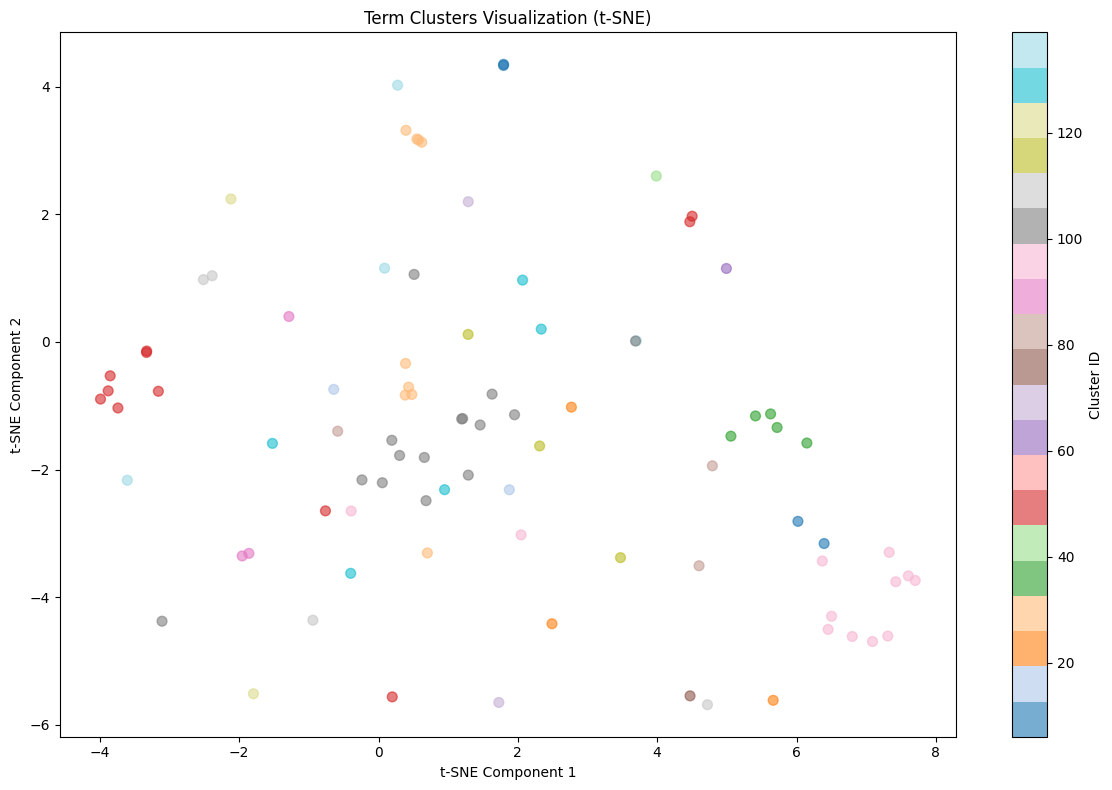

In [ ]:
# Example 3: Error Analysis
if config.EVALUATE_ON_DEV:
    print("\nExample 3: Error Analysis")
    print("=" * 60)
    
    gold = load_gold_standard(config.DEV_PATH)
    item_scores = analyze_errors(gold, clustering_result, top_n=10)
    
    # Visualize if embeddings available
    if SENTENCE_TRANSFORMERS_AVAILABLE:
        print("\nGenerating visualization...")
        try:
            visualize_clusters(dev_terms_list[:100], clustering_result)  # Limit for visualization
        except Exception as e:
            print(f"Visualization error: {e}") 

## 13. Development Dataset Evaluation

This section evaluates the pipeline on the development dataset and displays the BCubed F1 scores.


In [ ]:
# Evaluate on Development Dataset
print("=" * 80)
print("DEVELOPMENT DATASET EVALUATION")
print("=" * 80)
print("\nThis section evaluates the pipeline on the development set.")
print("Make sure you have trained on the training set first (Section 11.5).\n")

# Load development data
dev_terms = load_terms(config.DEV_PATH)
dev_terms_list = sorted(list(dev_terms))
dev_gold = load_gold_standard(config.DEV_PATH)

print(f"Development Set Statistics:")
print(f"  Total terms: {len(dev_terms_list)}")
print(f"  Total gold clusters: {len(set(dev_gold.values()))}\n")

# Save dev terms to temp file
import tempfile
import os
with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as f:
    pd.DataFrame({"term": dev_terms_list}).to_csv(f.name, index=False)
    temp_dev_file = f.name

# Run pipeline on development set
dev_output_file = f"{config.OUTPUT_PREFIX}_dev.{config.OUTPUT_FORMAT}"
dev_clustering = run_pipeline(
    input_file=temp_dev_file,
    method="hybrid",  # Use the same method as training
    output_file=dev_output_file,
    gold_standard_file=None,  # We'll evaluate manually
    use_llm=False,
    use_trained_params=True  # Use trained parameters
)

# Evaluate on development set
print(f"\n{'='*80}")
print(" DEVELOPMENT SET EVALUATION RESULTS")
print(f"{'='*80}")
dev_metrics = evaluate_clustering(dev_gold, dev_clustering, verbose=True)

# Display summary
print(f"\n{'='*80}")
print(" DEVELOPMENT SET SUMMARY")
print(f"{'='*80}")
print(f"BCubed Precision: {dev_metrics['precision']:.4f}")
print(f"BCubed Recall: {dev_metrics['recall']:.4f}")
print(f"BCubed F1 Score: {dev_metrics['f1']:.4f}")
print(f"{'='*80}\n")

# Compare with baseline if available
print("Comparison with Baseline:")
print("  Baseline (from task description): F1 = 0.260")
print(f"  Your Model: F1 = {dev_metrics['f1']:.4f}")
improvement = ((dev_metrics['f1'] - 0.260) / 0.260) * 100
print(f"  Improvement: {improvement:+.1f}%")
print() 

DEVELOPMENT DATASET EVALUATION

This section evaluates the pipeline on the development set.
Make sure you have trained on the training set first (Section 11.5).

Development Set Statistics:
  Total terms: 242
  Total gold clusters: 147

✓ Loaded trained parameters from: /Users/fashad/Desktop/SUBTASK-B/trained_parameters.json
  Optimal threshold: 0.850
  Method: hybrid
  Training F1: 0.5595


Running clustering pipeline
Method: hybrid
Using trained parameters (threshold: 0.850)

Loading terms...
Loaded 242 unique terms
Using hybrid clustering...
Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 242 terms using hybrid approach...
Step 1: Lemma-based grouping...


Lemmatizing terms:   0%|          | 0/242 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 242 terms...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]


✓ PREDICTION FILE SAVED!
  📁 Location: /Users/fashad/Desktop/SUBTASK-B/production_run_dev.csv
  📊 Format: CSV
  📝 Total terms: 242
  🔢 Total clusters: 140


Clustering Statistics:
Total terms: 242
Number of clusters: 140
Average cluster size: 1.73
Largest cluster size: 24
Singleton clusters: 112

📊 DEVELOPMENT SET EVALUATION RESULTS
BCubed Precision: 0.6481
BCubed Recall: 0.6908
BCubed F1 Score: 0.6688

📊 DEVELOPMENT SET SUMMARY
BCubed Precision: 0.6481
BCubed Recall:    0.6908
BCubed F1 Score:  0.6688

Comparison with Baseline:
  Baseline (from task description): F1 = 0.260
  Your Model:                      F1 = 0.6688
  Improvement:                      +157.2%



In [ ]:
# Optional: Show performance on both train and dev sets side by side
print("=" * 80)
print("COMPLETE PERFORMANCE SUMMARY (TRAIN + DEV)")
print("=" * 80)

# Load training results if available
train_metrics = None
if os.path.exists("trained_parameters.json"):
    import json
    with open("trained_parameters.json", 'r') as f:
        params = json.load(f)
    train_f1 = params.get('best_f1', None)
    if train_f1:
        # Re-run on training set to get full metrics
        train_terms = load_terms(config.TRAIN_PATH)
        train_terms_list = sorted(list(train_terms))
        train_gold = load_gold_standard(config.TRAIN_PATH)
        
        with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as f:
            pd.DataFrame({"term": train_terms_list}).to_csv(f.name, index=False)
            temp_train_file = f.name
        
        train_clustering = run_pipeline(
            input_file=temp_train_file,
            method="hybrid",
            output_file=None,
            gold_standard_file=None,
            use_llm=False,
            use_trained_params=True
        )
        
        train_metrics = evaluate_clustering(train_gold, train_clustering, verbose=False)

# Display comparison table
print(f"\n{'Dataset':<25} {'Precision':<15} {'Recall':<15} {'F1 Score':<15}")
print("-" * 80)
if train_metrics:
    print(f"{'Training Set':<25} {train_metrics['precision']:<15.4f} {train_metrics['recall']:<15.4f} {train_metrics['f1']:<15.4f}")
print(f"{'Development Set':<25} {dev_metrics['precision']:<15.4f} {dev_metrics['recall']:<15.4f} {dev_metrics['f1']:<15.4f}")
print("=" * 80)
print(f"\n Development Set BCubed F1: {dev_metrics['f1']:.4f}")
if train_metrics:
    print(f" Training Set BCubed F1: {train_metrics['f1']:.4f}")
print() 

COMPLETE PERFORMANCE SUMMARY (TRAIN + DEV)
✓ Loaded trained parameters from: /Users/fashad/Desktop/SUBTASK-B/trained_parameters.json
  Optimal threshold: 0.850
  Method: hybrid
  Training F1: 0.5595


Running clustering pipeline
Method: hybrid
Using trained parameters (threshold: 0.850)

Loading terms...
Loaded 713 unique terms
Using hybrid clustering...
Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully
Clustering 713 terms using hybrid approach...
Step 1: Lemma-based grouping...


Lemmatizing terms:   0%|          | 0/713 [00:00<?, ?it/s]

Step 2: Embedding-based refinement...
Computing embeddings for 713 terms...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]


⚠️  WARNING: No output file specified!
   Results were computed but NOT saved to file.
   To save your predictions, provide 'output_file' parameter:
   Example: run_pipeline(..., output_file='my_predictions.csv')


Clustering Statistics:
Total terms: 713
Number of clusters: 273
Average cluster size: 2.61
Largest cluster size: 146
Singleton clusters: 208

Dataset                   Precision       Recall          F1 Score       
--------------------------------------------------------------------------------
Training Set              0.5107          0.6186          0.5595         
Development Set           0.6481          0.6908          0.6688         

✅ Development Set BCubed F1: 0.6688
✅ Training Set BCubed F1:   0.5595



## 14. Test Dataset Evaluation and Prediction Generation

This section evaluates the pipeline on the test dataset (`test_data.csv`), generates predictions, and saves them to a CSV file. The test data has a different format (with document metadata), so we extract unique terms first.

**Note**: If you have a gold standard file for the test set, you can provide it for evaluation. Otherwise, this section will only generate predictions.


In [ ]:
# Test Dataset Evaluation and Prediction Generation
import os
import tempfile

print("=" * 80)
print("TEST DATASET EVALUATION AND PREDICTION GENERATION")
print("=" * 80)

# Step 1: Load test data and extract unique terms
test_file = "test_data.csv"
print(f"\nLoading test data from: {test_file}")

if not os.path.exists(test_file):
    print(f"ERROR: {test_file} not found!")
    print("Please ensure test_data.csv is in the current directory.")
else:
    # Read test data
    test_df = pd.read_csv(test_file)
    print(f"Total rows in test file: {len(test_df)}")
    
    # Extract unique terms (filter out empty/NaN terms)
    test_terms = test_df['term'].dropna().unique().tolist()
    test_terms = [term.strip() for term in test_terms if term.strip()]
    test_terms = sorted(list(set(test_terms)))  # Remove duplicates and sort
    
    print(f"Unique terms extracted: {len(test_terms)}")
    print(f"\nSample terms (first 10): {test_terms[:10]}")
    
    # Step 2: Create temporary input file with just terms
    temp_test_input = tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False)
    temp_test_df = pd.DataFrame({"term": test_terms})
    temp_test_df.to_csv(temp_test_input.name, index=False)
    temp_test_input.close()
    print(f"\nCreated temporary input file with {len(test_terms)} terms")
    
    # Step 3: Run pipeline on test data
    print(f"\n{'='*80}")
    print("RUNNING PIPELINE ON TEST DATA")
    print(f"{'='*80}")
    
    # Generate output filename
    test_output_file = f"{config.OUTPUT_PREFIX}_test.{config.OUTPUT_FORMAT}"
    
    # Check if gold standard exists for test data
    test_gold_file = None
    possible_gold_files = [
        "subtask_b_test.csv",
        "test_gold.csv",
        "test_data_gold.csv"
    ]
    for gold_file in possible_gold_files:
        if os.path.exists(gold_file):
            test_gold_file = gold_file
            print(f"Found gold standard file: {gold_file}")
            break
    
    # Run pipeline
    test_clustering = run_pipeline(
        input_file=temp_test_input.name,
        method="strict",  # Use strict method (can be changed)
        output_file=test_output_file,
        gold_standard_file=test_gold_file,
        use_llm=False,  # Set to True if you want LLM refinement (slower)
        use_trained_params=True  # Use trained parameters from training set
    )
    
    # Step 4: Evaluate if gold standard is available
    if test_gold_file:
        print(f"\n{'='*80}")
        print(" TEST SET EVALUATION RESULTS")
        print(f"{'='*80}")
        test_gold = load_gold_standard(test_gold_file)
        test_metrics = evaluate_clustering(test_gold, test_clustering, verbose=True)
        
        print(f"\n{'='*80}")
        print(" FINAL TEST SET RESULTS")
        print(f"{'='*80}")
        print(f"BCubed Precision: {test_metrics['precision']:.4f}")
        print(f"BCubed Recall: {test_metrics['recall']:.4f}")
        print(f"BCubed F1 Score: {test_metrics['f1']:.4f}")
        print(f"{'='*80}\n")
        
        # Compare with train/dev if available
        print(f"\n{'='*80}")
        print(" COMPLETE PERFORMANCE SUMMARY (TRAIN + DEV + TEST)")
        print(f"{'='*80}")
        print(f"{'Dataset':<25} {'Precision':<15} {'Recall':<15} {'F1 Score':<15}")
        print("-" * 80)
        
        # Try to load train metrics
        try:
            train_terms = load_terms(config.TRAIN_PATH)
            train_terms_list = sorted(list(train_terms))
            train_gold = load_gold_standard(config.TRAIN_PATH)
            with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as f:
                pd.DataFrame({"term": train_terms_list}).to_csv(f.name, index=False)
                temp_train_file = f.name
            train_clustering = run_pipeline(
                input_file=temp_train_file,
                method="hybrid",
                output_file=None,
                gold_standard_file=None,
                use_llm=False,
                use_trained_params=True
            )
            train_metrics = evaluate_clustering(train_gold, train_clustering, verbose=False)
            print(f"{'Training Set':<25} {train_metrics['precision']:<15.4f} {train_metrics['recall']:<15.4f} {train_metrics['f1']:<15.4f}")
        except:
            pass
        
        # Try to load dev metrics
        try:
            dev_terms = load_terms(config.DEV_PATH)
            dev_terms_list = sorted(list(dev_terms))
            dev_gold = load_gold_standard(config.DEV_PATH)
            with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as f:
                pd.DataFrame({"term": dev_terms_list}).to_csv(f.name, index=False)
                temp_dev_file = f.name
            dev_clustering = run_pipeline(
                input_file=temp_dev_file,
                method="hybrid",
                output_file=None,
                gold_standard_file=None,
                use_llm=False,
                use_trained_params=True
            )
            dev_metrics = evaluate_clustering(dev_gold, dev_clustering, verbose=False)
            print(f"{'Development Set':<25} {dev_metrics['precision']:<15.4f} {dev_metrics['recall']:<15.4f} {dev_metrics['f1']:<15.4f}")
        except:
            pass
        
        print(f"{'Test Set':<25} {test_metrics['precision']:<15.4f} {test_metrics['recall']:<15.4f} {test_metrics['f1']:<15.4f}")
        print(f"{'='*80}\n")
    else:
        print(f"\n{'='*80}")
        print(" TEST SET PREDICTIONS GENERATED")
        print(f"{'='*80}")
        print(f"Predictions saved to: {os.path.abspath(test_output_file)}")
        print(f"Total terms clustered: {len(test_clustering)}")
        print(f"Total clusters: {len(set(test_clustering.values()))}")
        print(f"\nWARNING: No gold standard file found for test data.")
        print("Predictions have been generated but cannot be evaluated.")
        print("To evaluate, provide a gold standard file with one of these names:")
        for gold_file in possible_gold_files:
            print(f"  - {gold_file}")
        print(f"{'='*80}\n")
    
    # Clean up temporary file
    try:
        os.unlink(temp_test_input.name)
    except:
        pass 

TEST DATASET EVALUATION AND PREDICTION GENERATION

📂 Loading test data from: test_data.csv
   Total rows in test file: 1368
   Unique terms extracted: 335

   Sample terms (first 10): ['a-porta', 'abbandono', 'abbandono dei rifiuti', 'abbandono di materiali', 'abbandono irregolare dei rifiuti', 'alluminio', "appalto d'igiene urbana e servizi", 'aree attrezzate per la raccolta dei rifiuti differenziati', 'aree di raccolta', 'aree di sosta temporanea']

✓ Created temporary input file with 335 terms

RUNNING PIPELINE ON TEST DATA

Running clustering pipeline
Method: strict

Loading terms...
Loaded 335 unique terms
Using strict hybrid clustering (anti-monster cluster pipeline)...
Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded successfully

STRICT HYBRID CLUSTERING PIPELINE
Clustering 335 terms with anti-monster cluster system...
Similarity threshold: 0.90
Monster cluster threshold: 10 items
LLM verification: OFF

Module 1: Acronym & Substring Solver
  Processin

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Module 2: Refined Embedding Clustering (Anti-Lumping)
  Using strict threshold: 0.90
  ✓ Merged 0 cluster pairs (strict threshold applied)
  ✓ Final clusters: 200

Module 3: Monster Cluster Breaker
  ✓ No monster clusters found (all clusters ≤ 10 items)

Module 4: LLM Edge Verification - SKIPPED (use_llm_verification=False)

CLUSTERING COMPLETE
Total clusters: 200
Average cluster size: 1.68
Largest cluster: 9 items
Singleton clusters: 139


✓ PREDICTION FILE SAVED!
  📁 Location: /Users/fashad/Desktop/SUBTASK-B/production_run_test.csv
  📊 Format: CSV
  📝 Total terms: 335
  🔢 Total clusters: 200


Clustering Statistics:
Total terms: 335
Number of clusters: 200
Average cluster size: 1.68
Largest cluster size: 9
Singleton clusters: 139

📊 TEST SET PREDICTIONS GENERATED
✓ Predictions saved to: /Users/fashad/Desktop/SUBTASK-B/production_run_test.csv
✓ Total terms clustered: 335
✓ Total clusters: 200

⚠️  Note: No gold standard file found for test data.
   Predictions have been generated but